# Start Pooling

In [1]:
#import general packages
import numpy as np
import dill
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import exposures as ex
import n_fct_t_rl_thm_ll as bond_fct
import grider as grd
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo
import simulate_multi_cty_bond as smcb
client = Client()

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


## Define Countries and Variables for Cat Bond Development

In [ ]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
#basins = ['NA','SI']

#choose country
country_1 = 659
country_2 = 308
countries = [str(country_1), str(country_2)]

#minimum damage to be protected per grid cell calculated using return period
lower_rp_c1 = 25
lower_rp_c2 = 25
higher_rp_c1 = 130
higher_rp_c2 = 80

to_prot_share_c1 = 0.04
to_prot_share_c2 = 0.02

#number of simulated years
r = 10000
#number of Monte-Carlo simulations
num_simulations = 10001 - 3


#set risk free rate, either single value or array
rf_rate = 0.00

#set sharpe ratio to beat
requ_sharpe_ratio = 0.5

#set the maximum amount to be protected
prot_share_arr = np.arange(0.02, 0.51, 0.03) #protected share of total exposure

## Designe Single Country Bonds
### Define Cat Bond function

### Design Cat Bond for Country 1

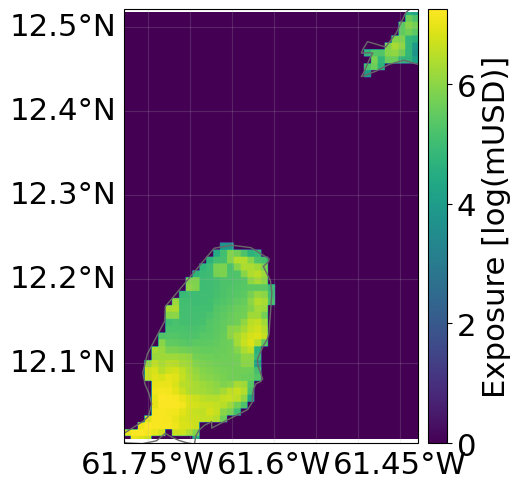

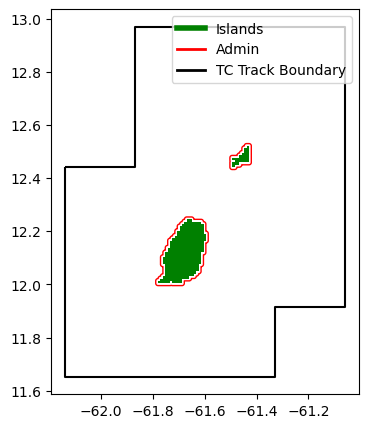

Number of tracks in NA basin: 2692


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\impact.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


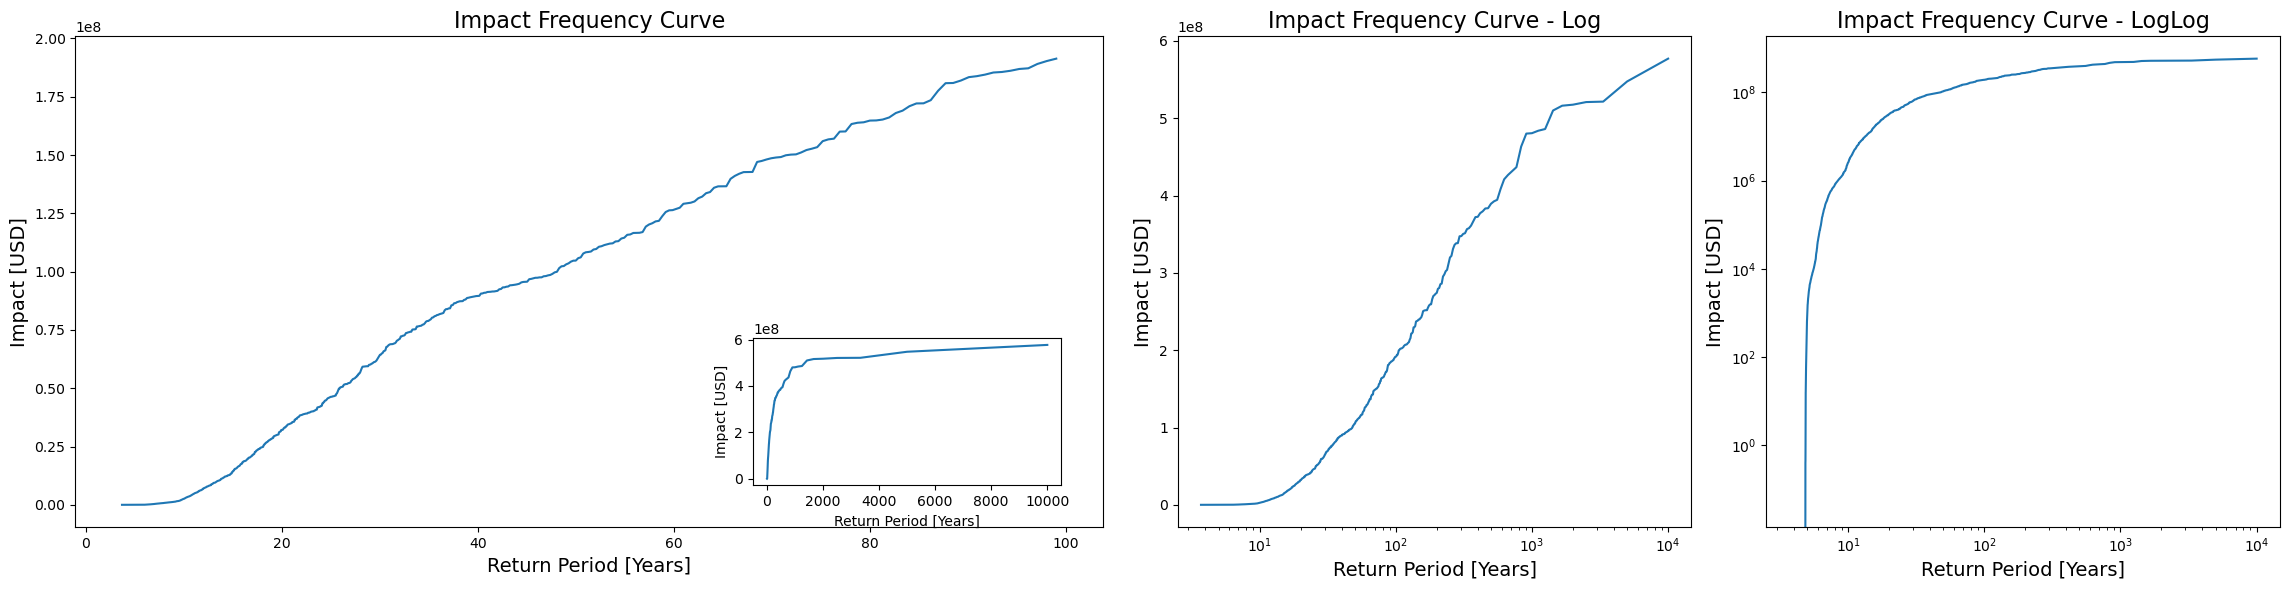

The principal of the cat bond is: 20868222.222 [USD]
Principal as share of GDP: 0.02
The specified damage which should be covered is:  46290407.319  [USD]

{0: (36.45496494255531, 36.4530228654384), 1: (38.79829648705177, 38.79868319192986)}


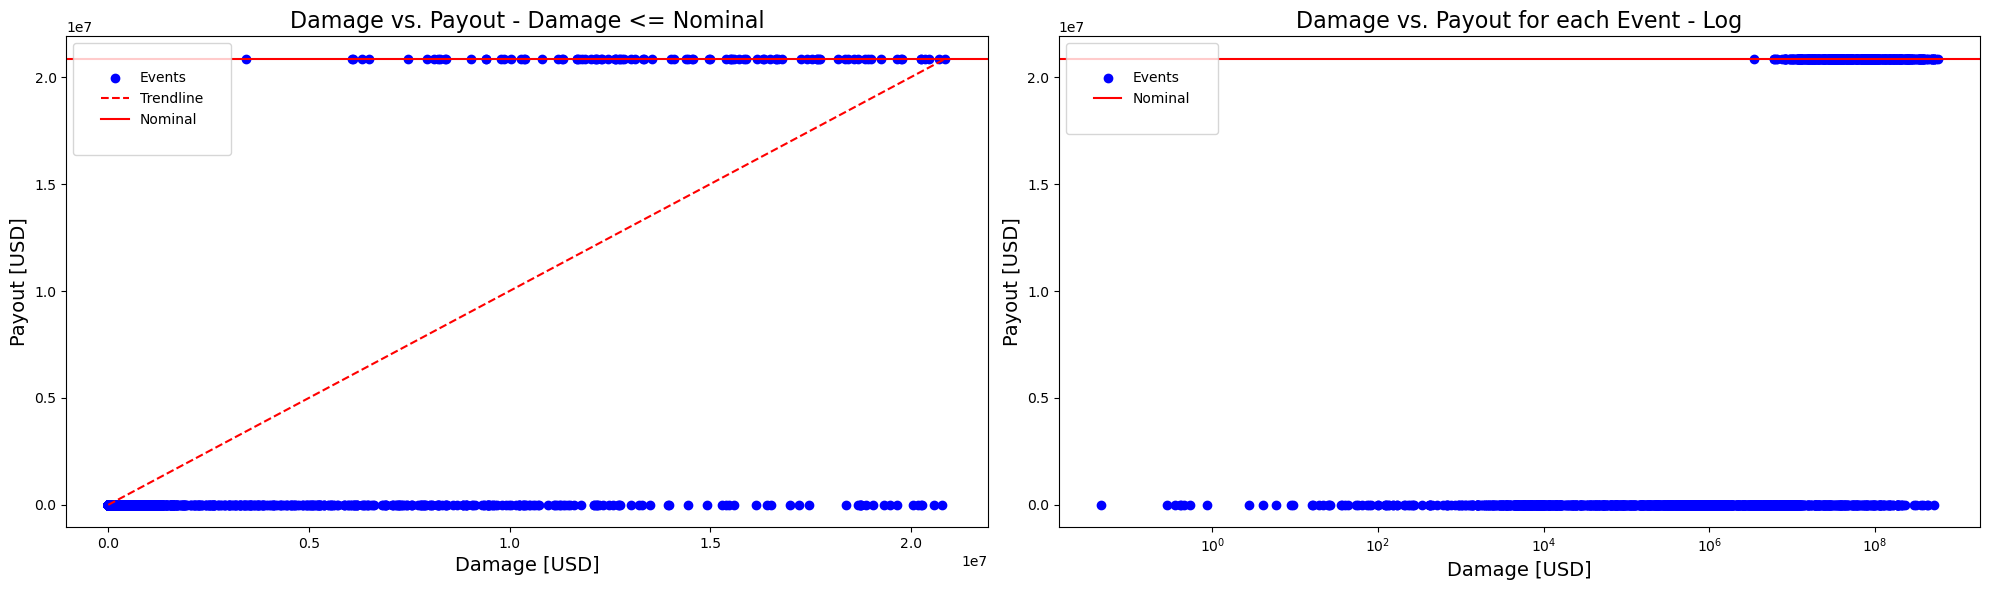

KeyboardInterrupt: 

In [ ]:
premium_simulation_ps_c1, returns_ps_c1, premium_dic_c1, nom_arr_c1, pay_dam_df_ps_c1, es_metrics_ps_c1, int_grid_c1, imp_per_event_flt_c1, imp_admin_evt_flt_c1 = bond_fct.init_sng_cty_bond_principal(country_1, prot_share_arr, rf_rate, requ_sharpe_ratio, low_to_prot=lower_rp_c1, incl_plots=False, int_ws=True)

### Design Cat Bond for Country 2

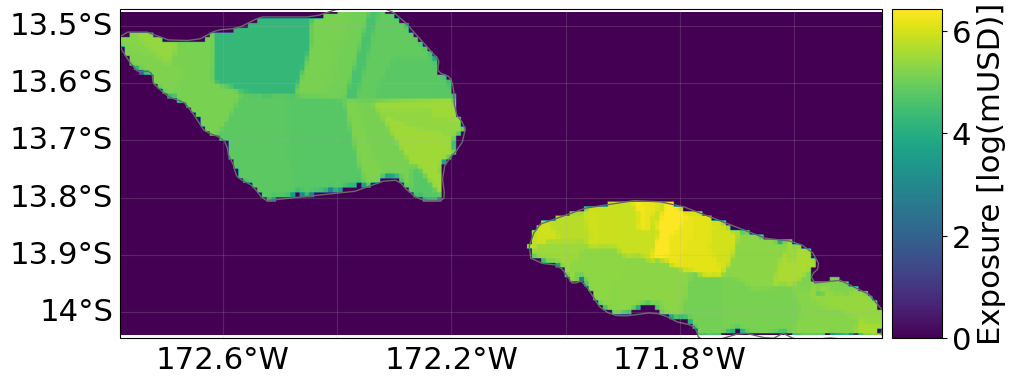

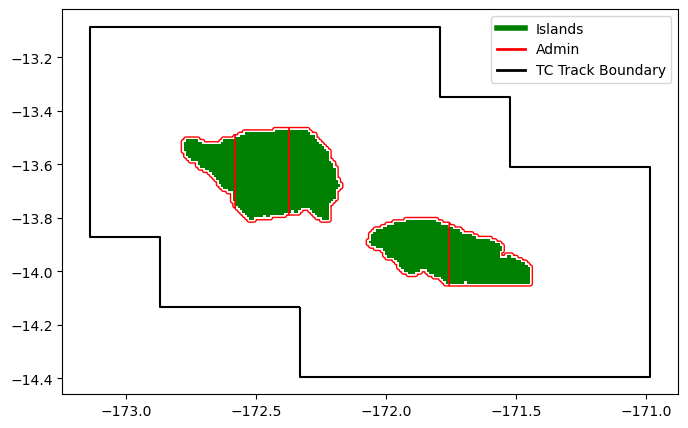

Number of tracks in SP basin: 1767


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\impact.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


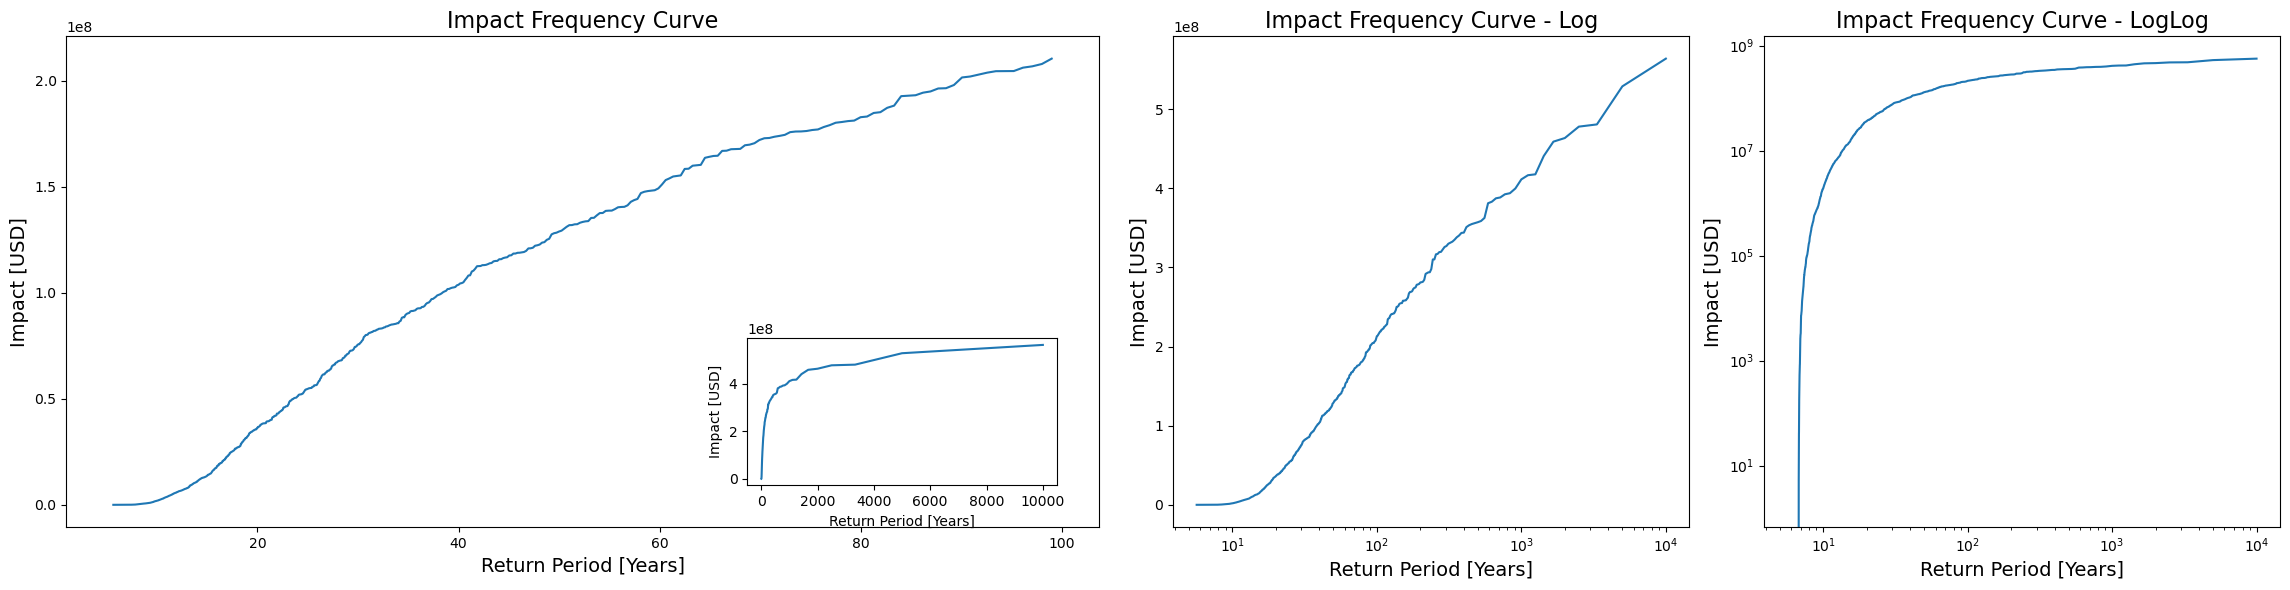

The principal of the cat bond is: 17377967.165 [USD]
Principal as share of GDP: 0.02
The specified damage which should be covered is:  54681874.233  [USD]

{0: (42.06289424656015, 43.00225551966185), 1: (42.32986322684354, 46.07985646601501), 2: (48.27494566466055, 62.584230178401626), 3: (45.76005743221233, 61.70121705229252), 4: (43.26724389367857, 53.277590253117125)}


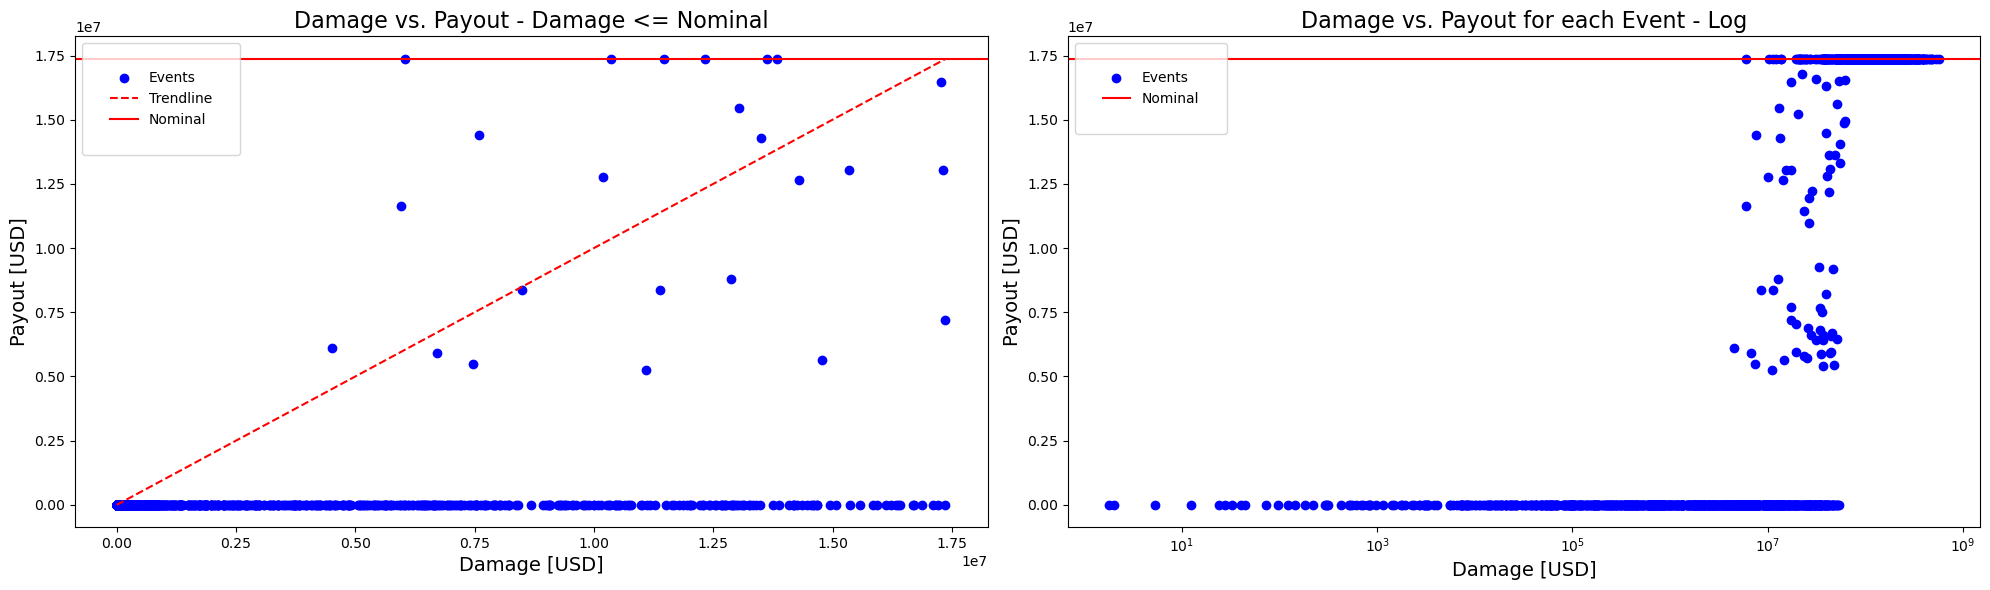

The principal of the cat bond is: 43444917.913 [USD]
Principal as share of GDP: 0.05
The specified damage which should be covered is:  54681874.233  [USD]

{0: (42.162764650792816, 46.2265580319185), 1: (44.57632247441271, 54.8184319786077), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (48.16263454483974, 65.44226586250525)}


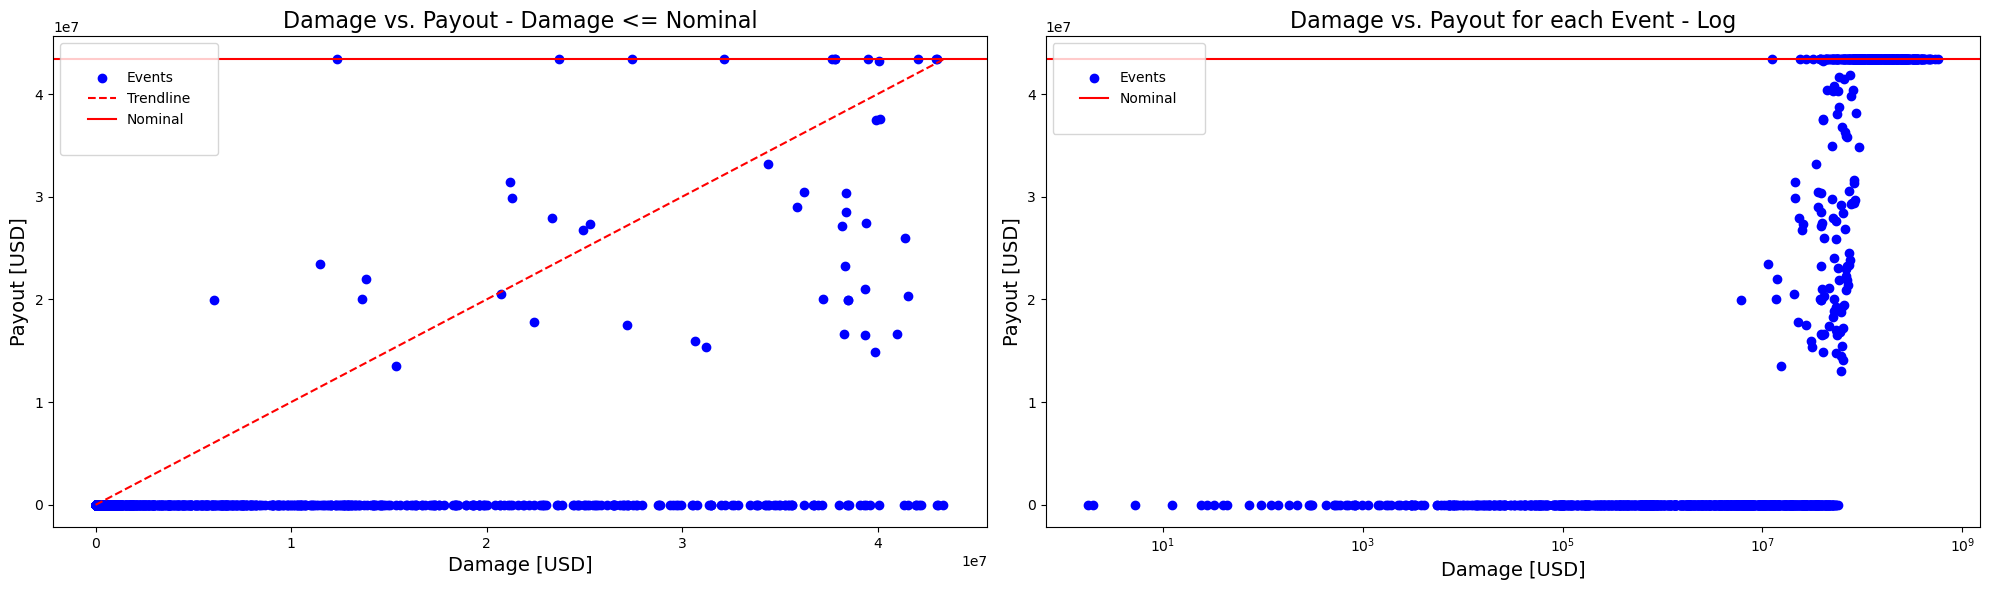

The principal of the cat bond is: 69511868.661 [USD]
Principal as share of GDP: 0.08
{0: (42.48470792727192, 50.04333795142092), 1: (46.67661643620227, 60.61352131979858), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


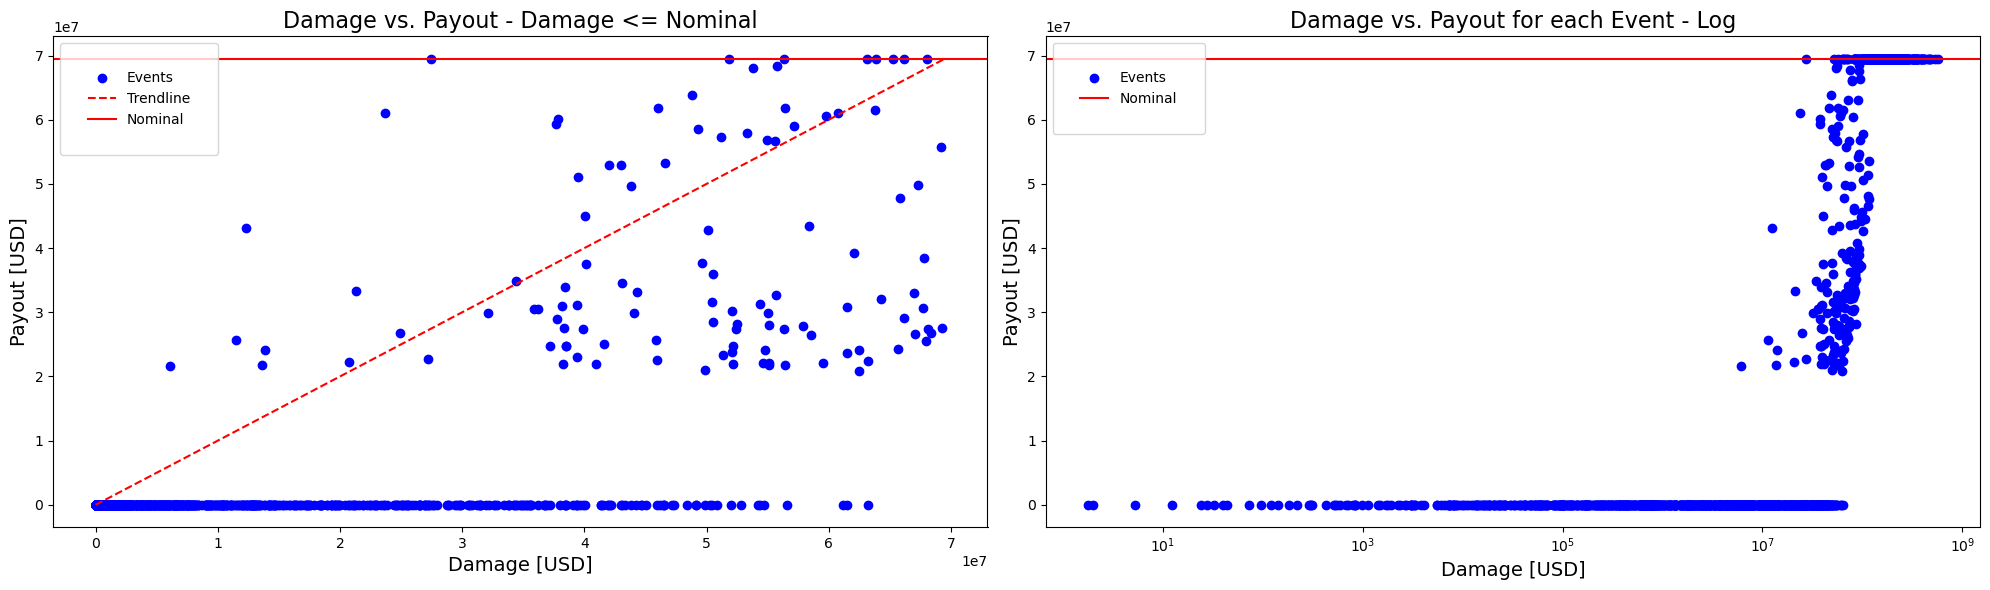

The principal of the cat bond is: 95578819.409 [USD]
Principal as share of GDP: 0.11
{0: (43.286312323134275, 51.63664979111365), 1: (48.21268742974561, 64.92834984678575), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


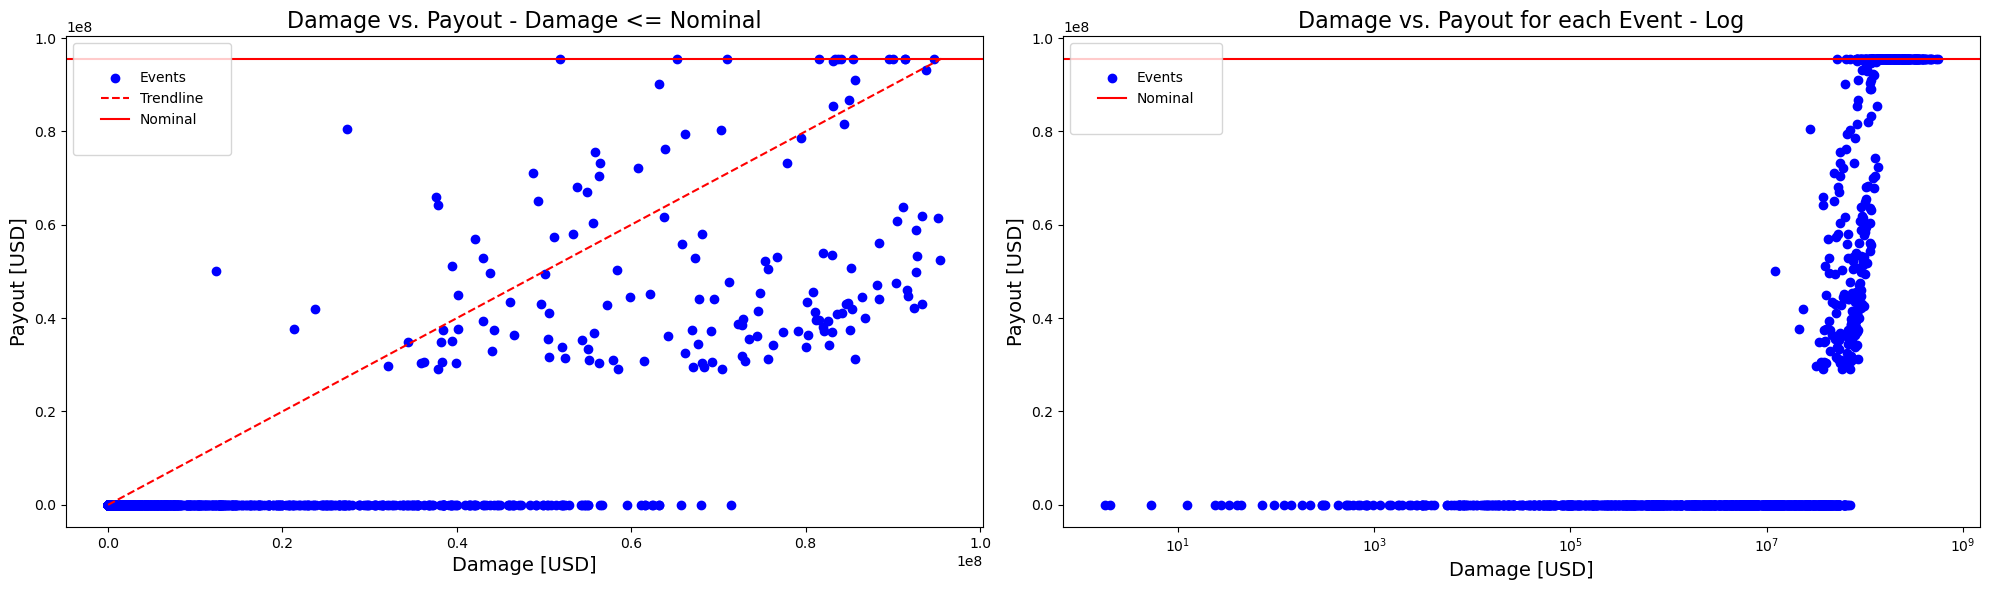

The principal of the cat bond is: 121645770.157 [USD]
Principal as share of GDP: 0.14
{0: (44.30730317741167, 55.28397549155725), 1: (50.47492948374335, 71.00897099225313), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


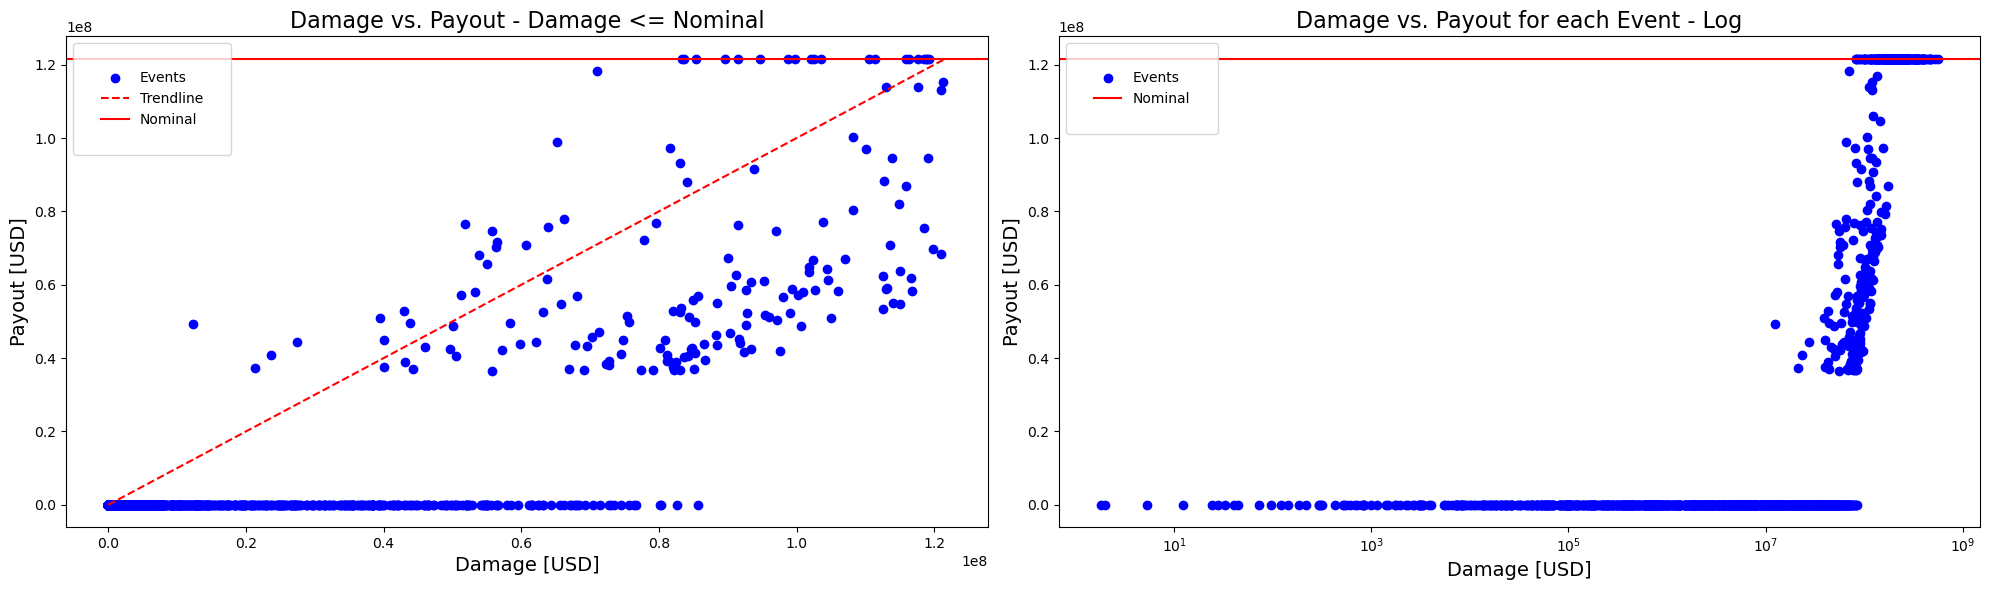

The principal of the cat bond is: 147712720.905 [USD]
Principal as share of GDP: 0.17
{0: (44.24784839622598, 58.53689869460096), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


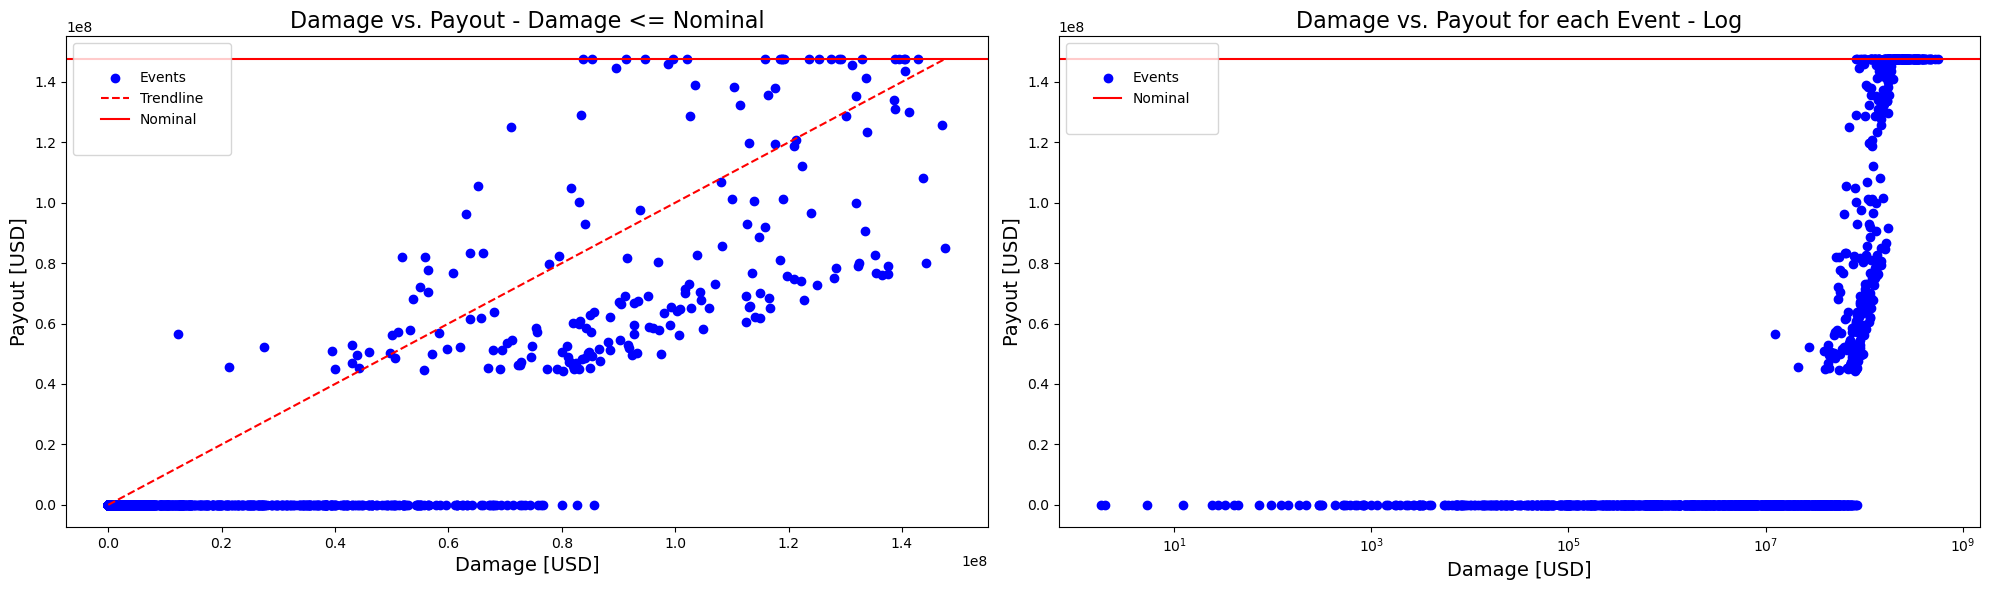

The principal of the cat bond is: 173779671.653 [USD]
Principal as share of GDP: 0.2
{0: (44.457490191584135, 62.66895647196992), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


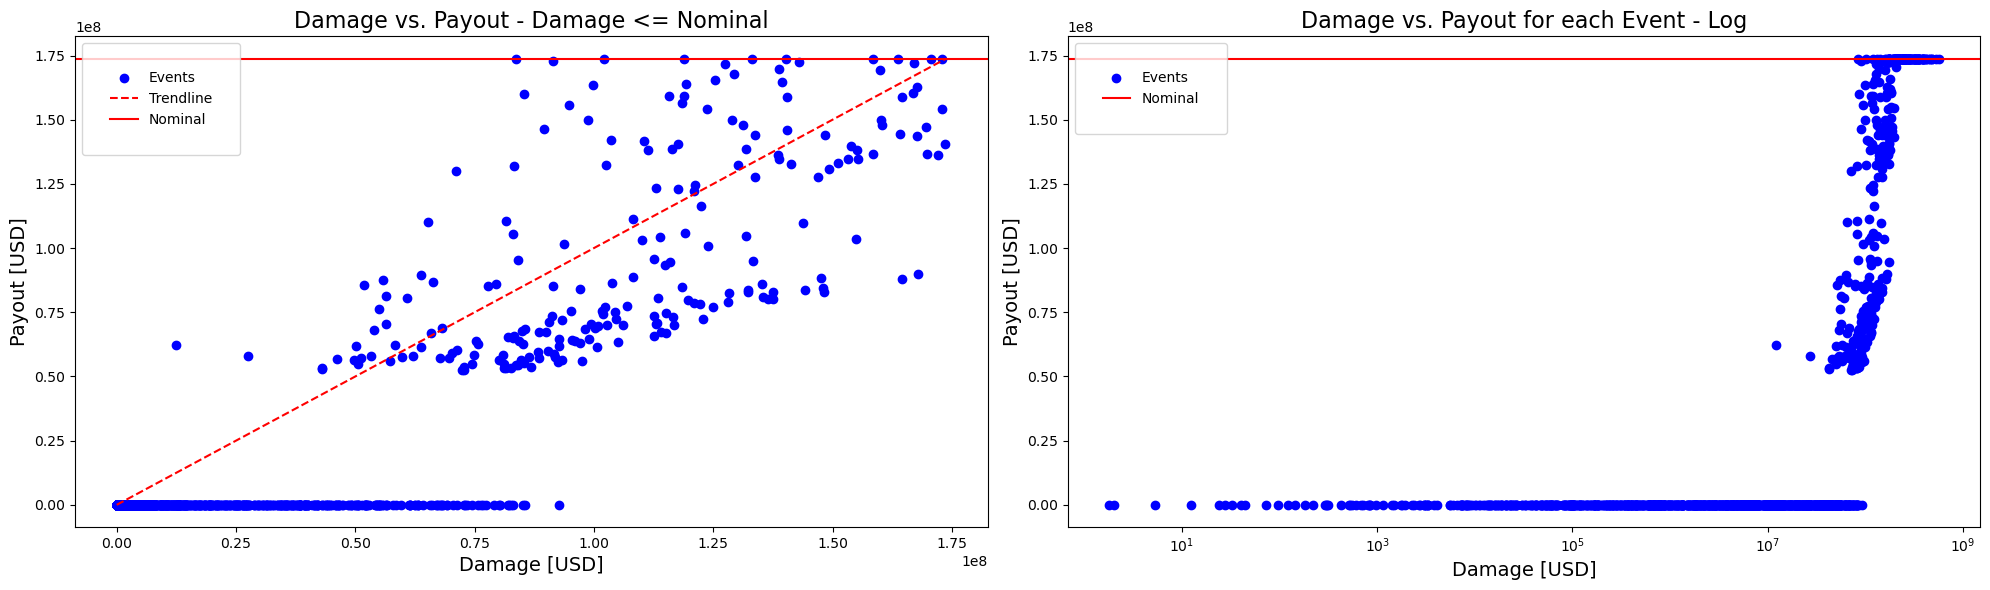

The principal of the cat bond is: 199846622.401 [USD]
Principal as share of GDP: 0.23
{0: (46.11015808023677, 64.41555853020012), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


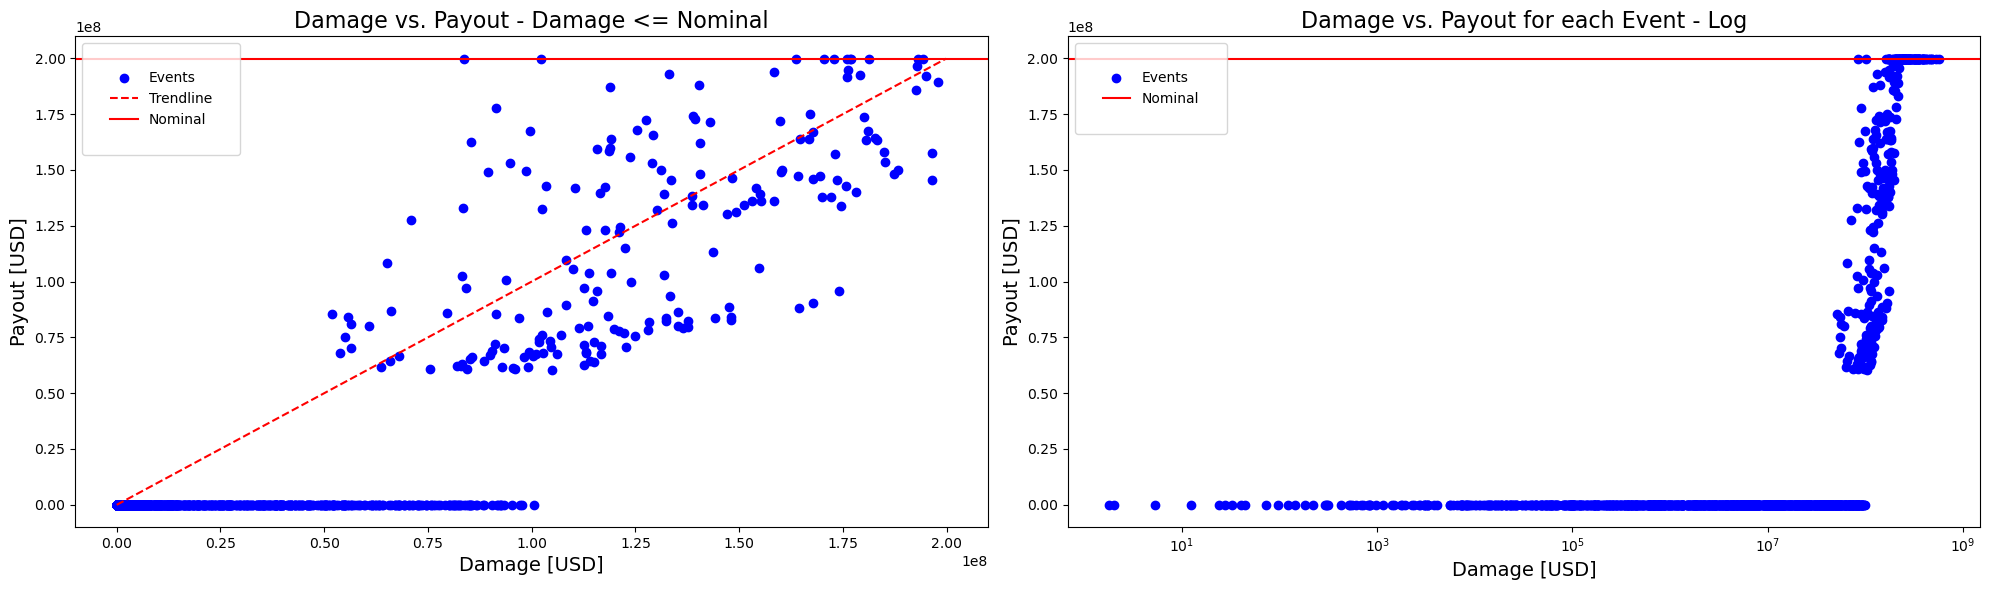

The principal of the cat bond is: 225913573.149 [USD]
Principal as share of GDP: 0.26
{0: (46.172314865203056, 67.27311899292836), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


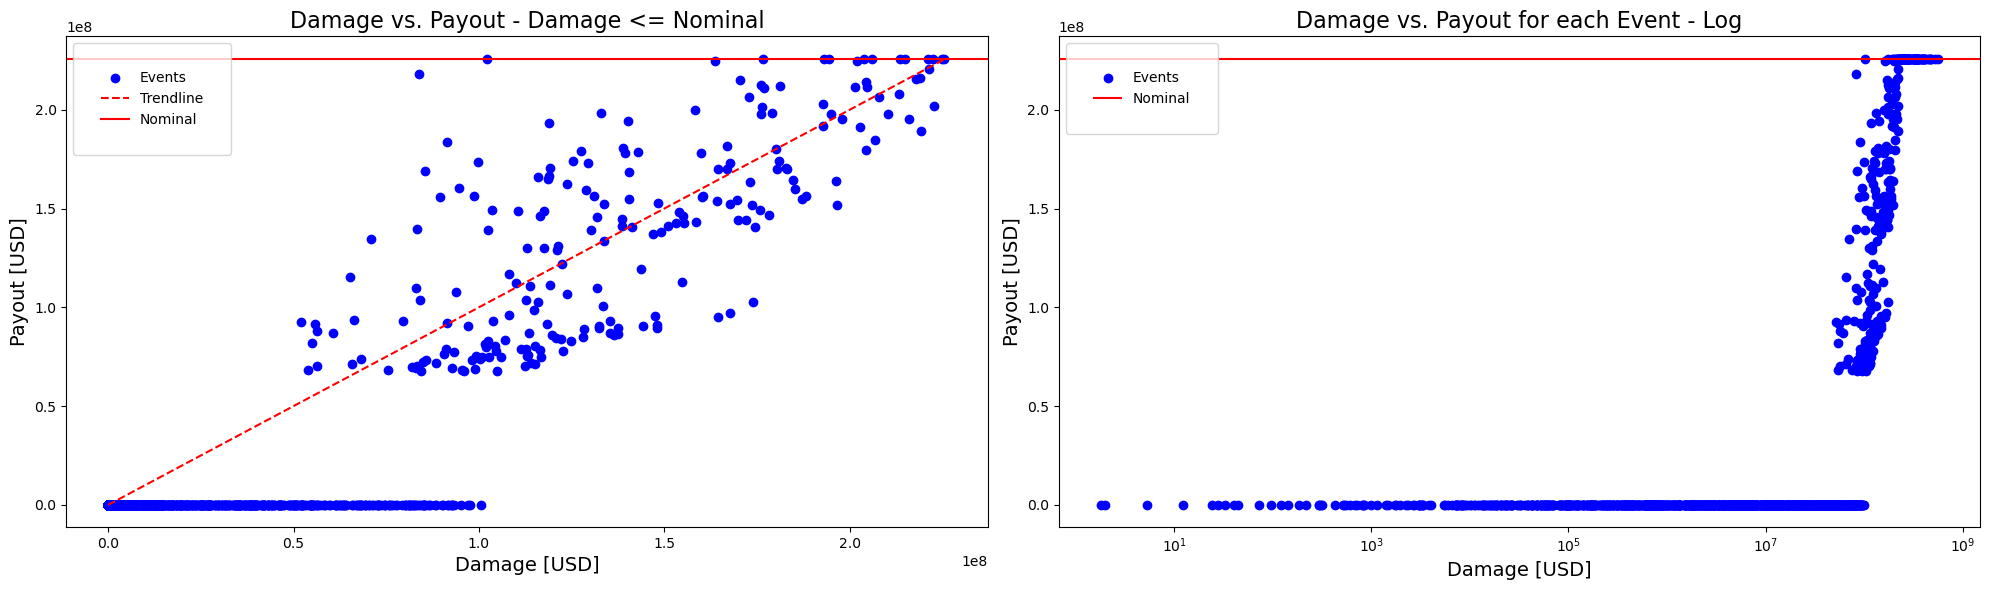

The principal of the cat bond is: 251980523.897 [USD]
Principal as share of GDP: 0.29
{0: (46.91654314298048, 69.19847038575462), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


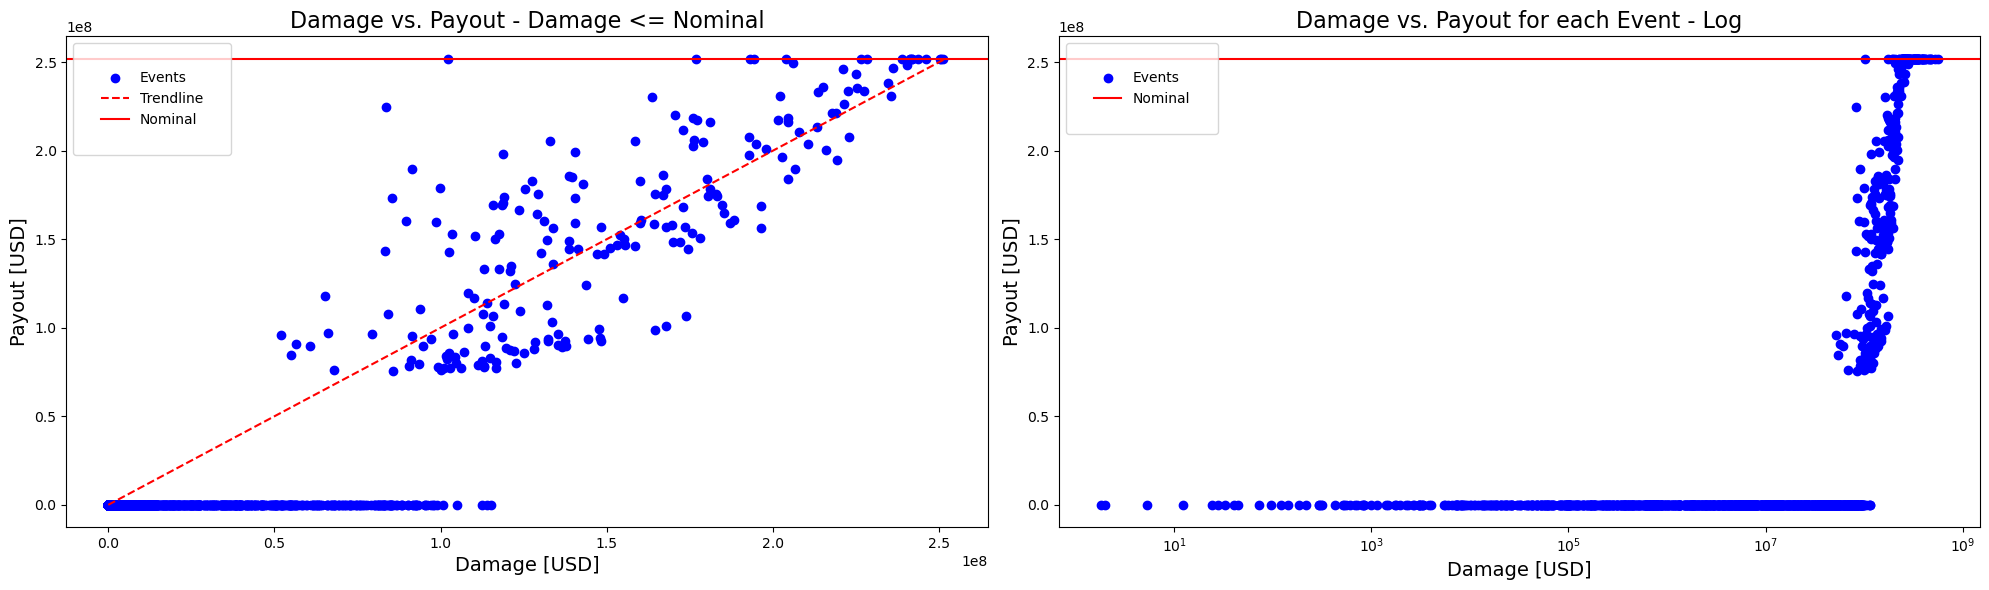

The principal of the cat bond is: 278047474.645 [USD]
Principal as share of GDP: 0.32
{0: (47.09508177988788, 72.92970987639796), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


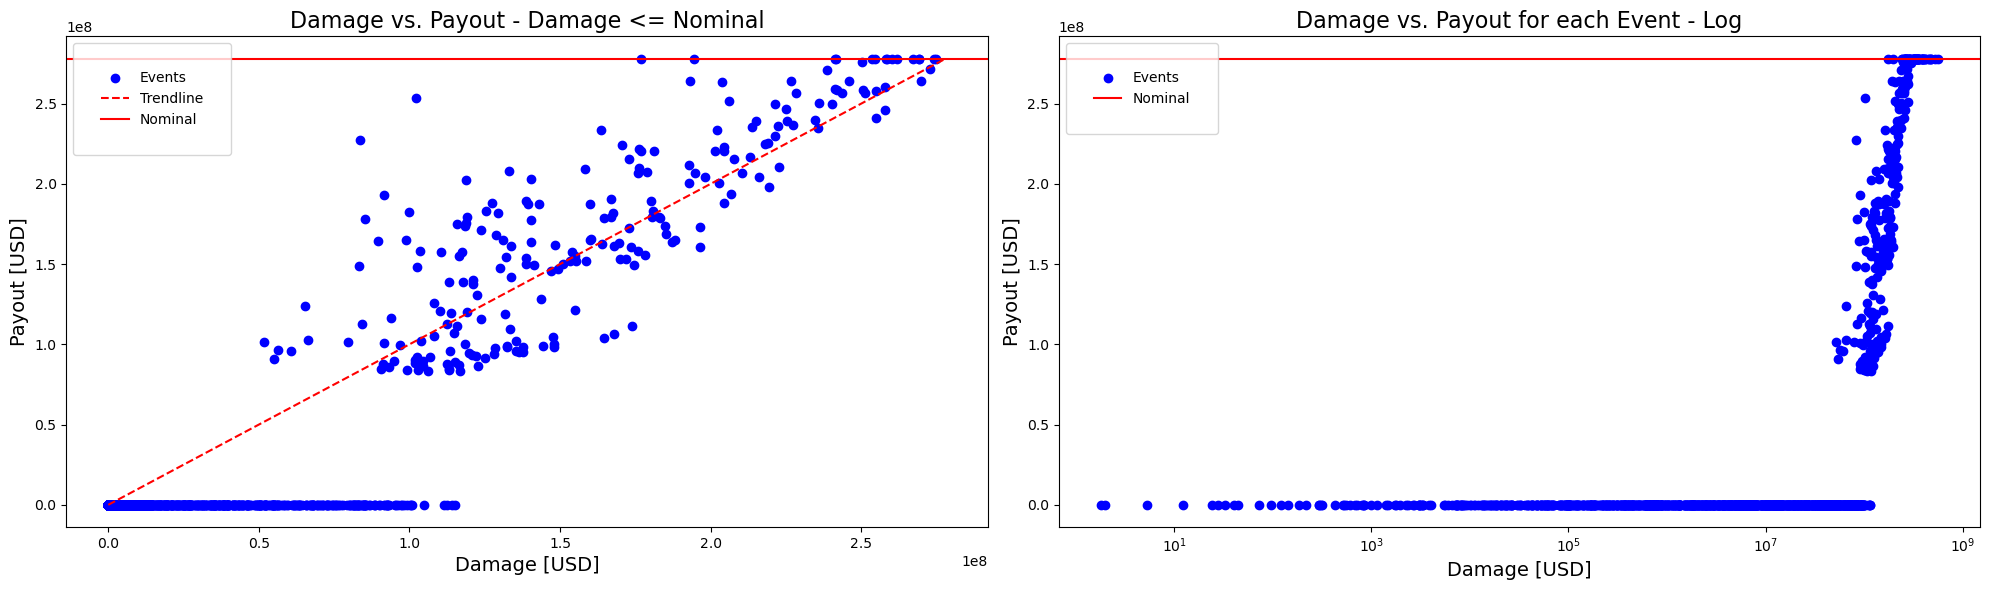

The principal of the cat bond is: 304114425.393 [USD]
Principal as share of GDP: 0.35
{0: (47.09503297727585, 78.77902544296286), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


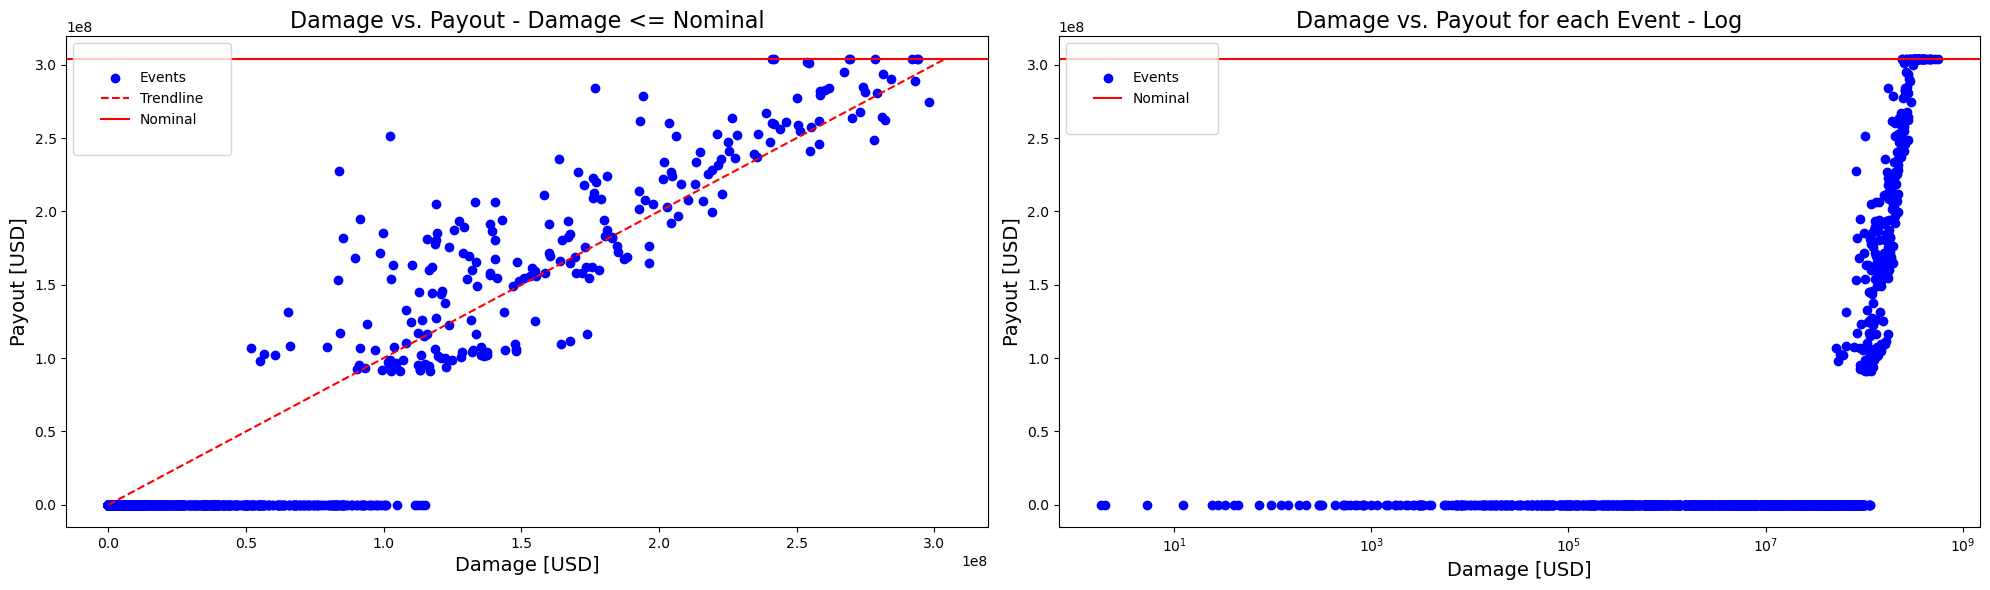

The principal of the cat bond is: 330181376.141 [USD]
Principal as share of GDP: 0.38
{0: (48.11289659770819, 77.02433260685844), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


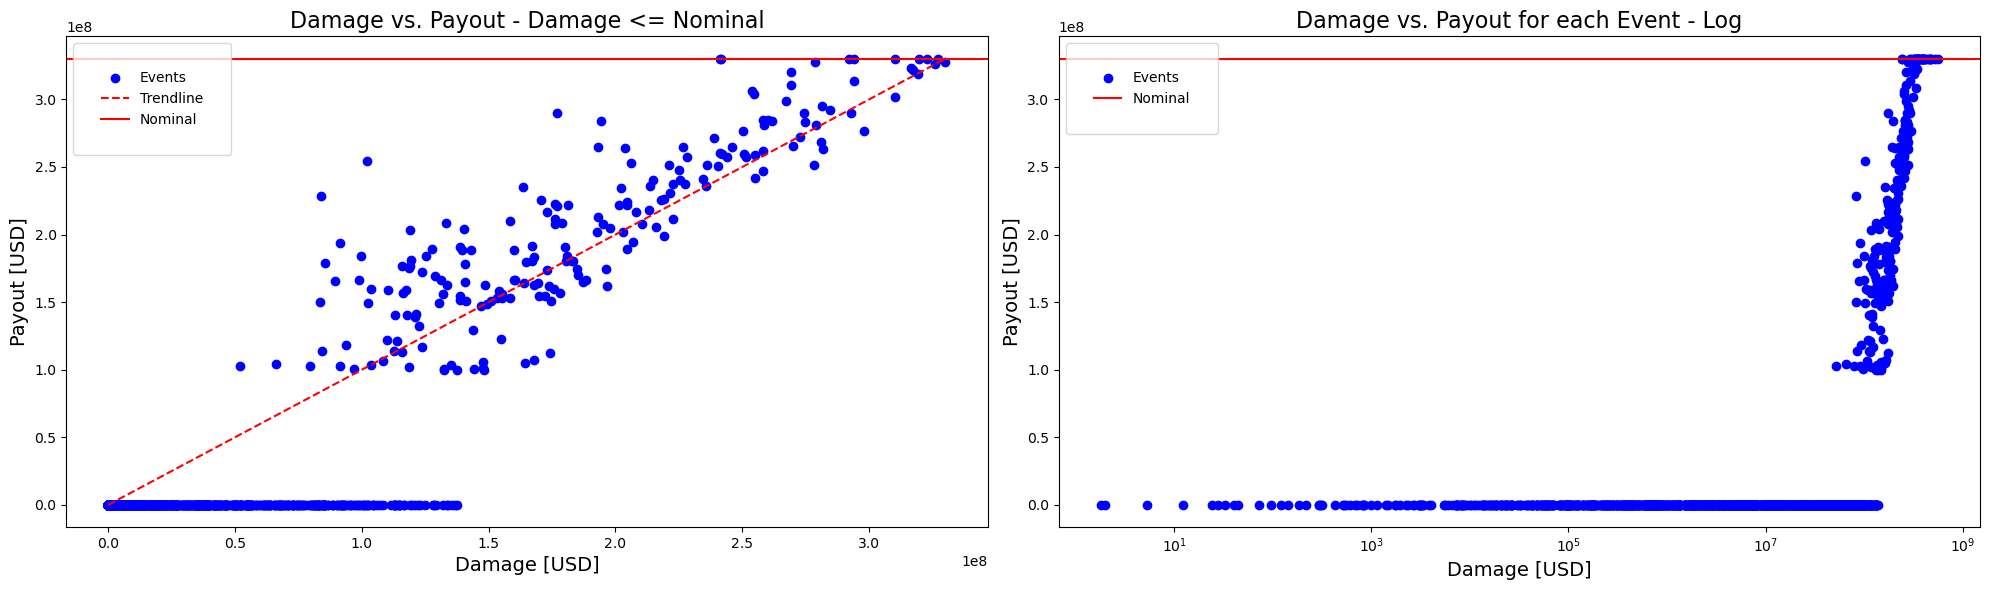

The principal of the cat bond is: 356248326.889 [USD]
Principal as share of GDP: 0.41
{0: (48.11289659770819, 77.02433260685844), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


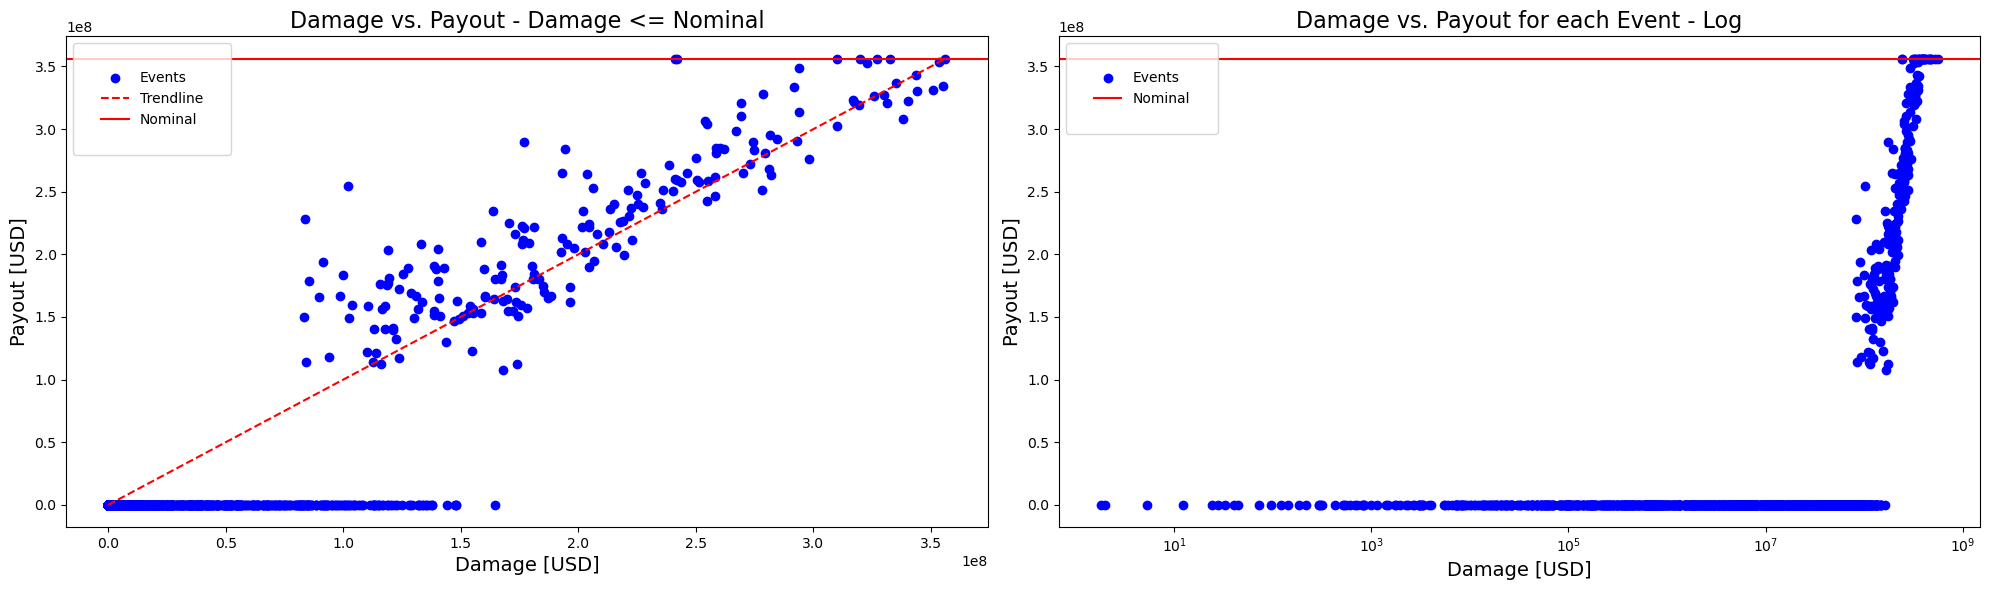

The principal of the cat bond is: 382315277.637 [USD]
Principal as share of GDP: 0.44
{0: (48.11289659770819, 77.02433260685844), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


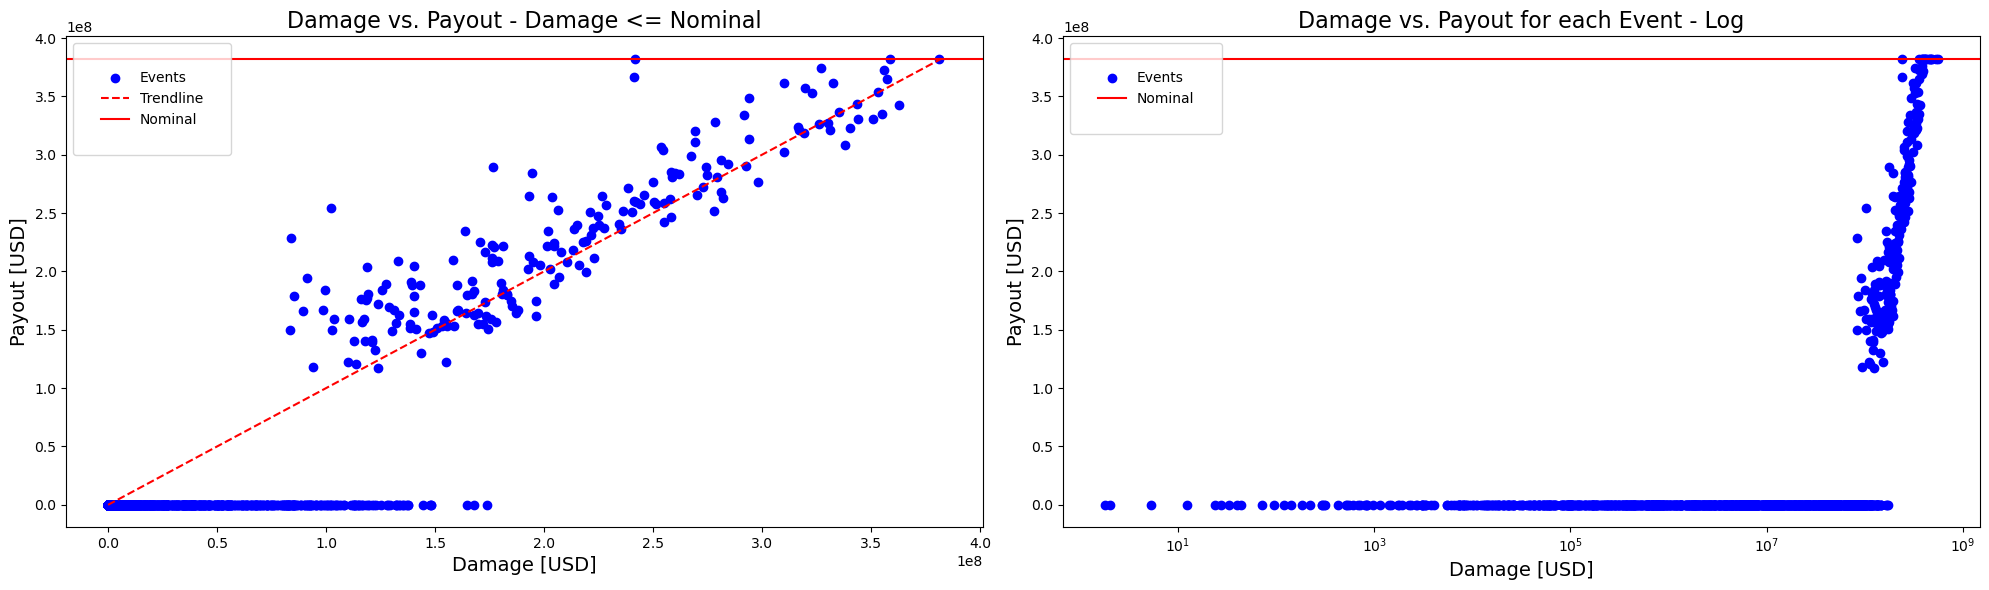

The principal of the cat bond is: 408382228.385 [USD]
Principal as share of GDP: 0.47
{0: (48.11289659770819, 77.02433260685844), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


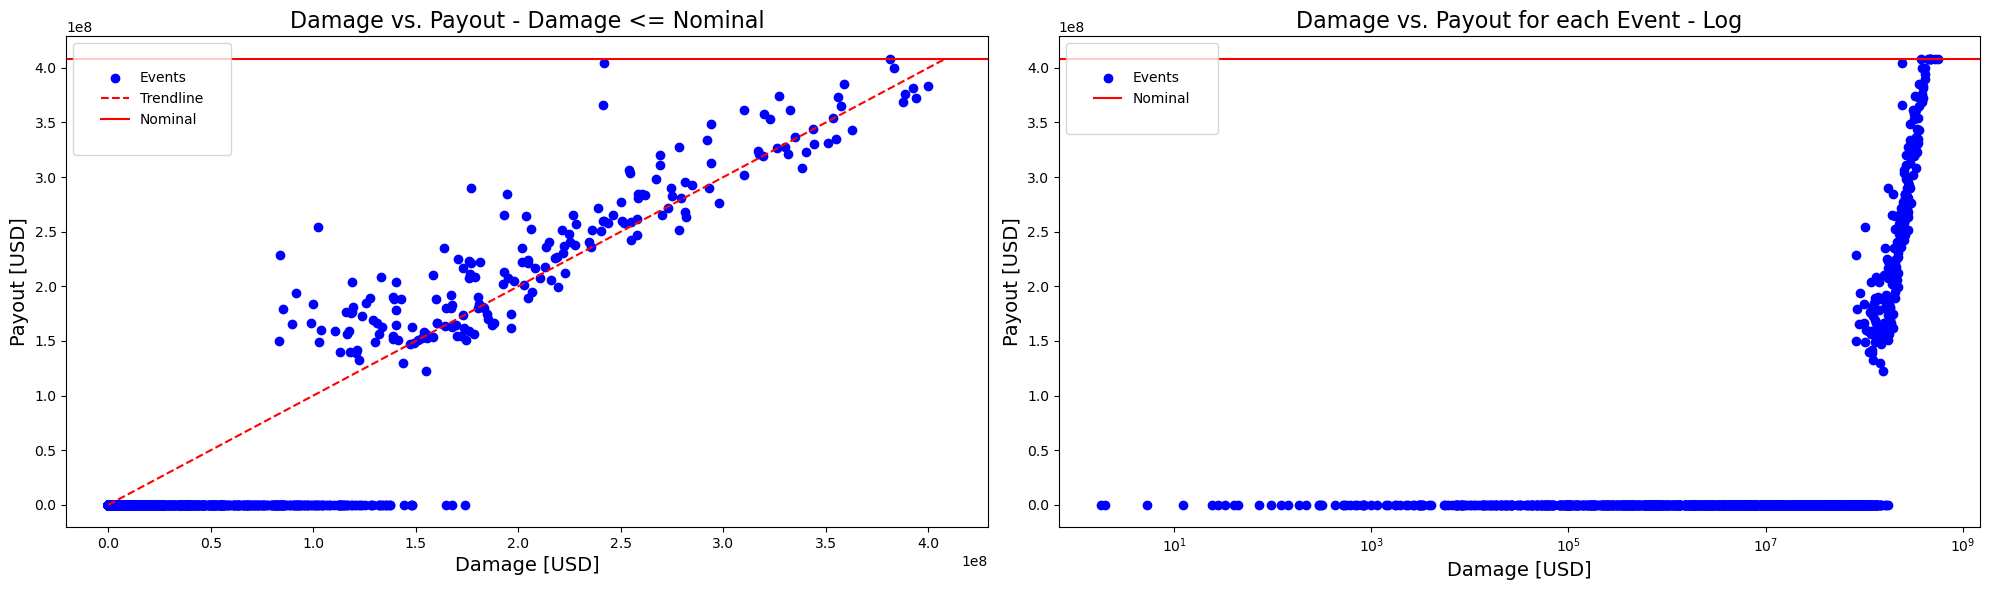

The principal of the cat bond is: 434449179.133 [USD]
Principal as share of GDP: 0.5
{0: (48.11289659770819, 77.02433260685844), 1: (50.45749762235634, 72.86601279737025), 2: (52.94656912636992, 73.0994096313795), 3: (53.11994261074606, 72.9833261612373), 4: (51.61697227709428, 74.46353278657527)}


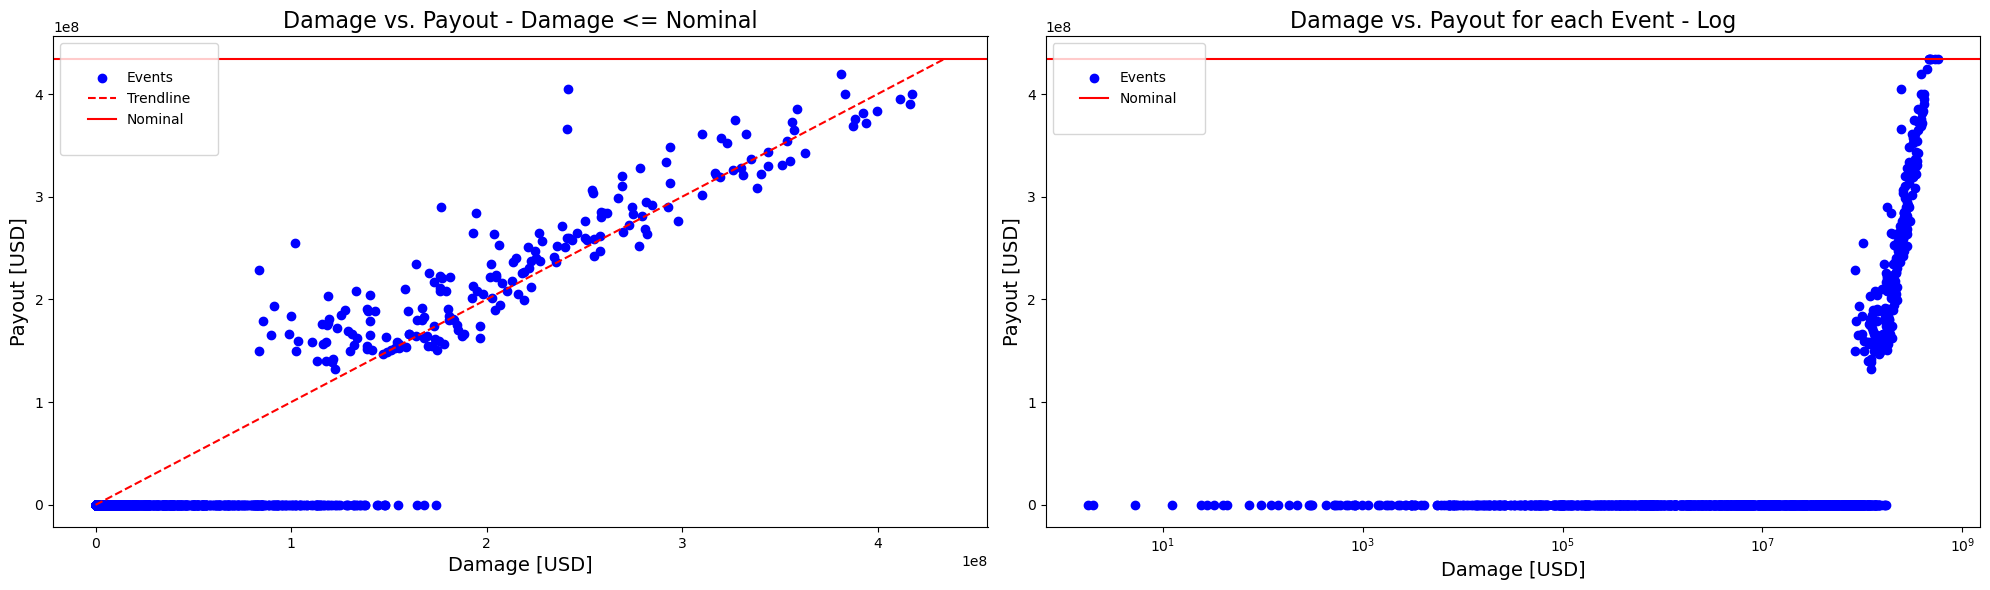

In [10]:
premium_simulation_ps_c2, returns_ps_c2, premium_dic_c2, nom_arr_c2, pay_dam_df_ps_c2, es_metrics_ps_c2, int_grid_c2, imp_per_event_flt_c2, imp_admin_evt_flt_c2 = bond_fct.init_sng_cty_bond_principal(country_2, prot_share_arr, rf_rate, requ_sharpe_ratio, low_to_prot=lower_rp_c2, incl_plots=True,int_ws=True)

## Design Multi-Country Bond
### Set Variables for Multi-Country Bond

In [11]:
nominal_pool = [e1 + e2 for e1, e2 in zip(nom_arr_c1, nom_arr_c2)]
nominal_dic = {country_1: nom_arr_c1,
               country_2: nom_arr_c2}
pay_dam_df_dic_ps = {country_1: pay_dam_df_ps_c1,
                     country_2: pay_dam_df_ps_c2}
int_grid_dic = {country_1: int_grid_c1,
                country_2: int_grid_c2}
damages_grid_flt_dic = {country_1: imp_admin_evt_flt_c1,
                        country_2: imp_admin_evt_flt_c2}
damages_evt_flt_dic = {country_1: imp_per_event_flt_c1,
                       country_2: imp_per_event_flt_c2}

### Optimize Premiums

In [51]:
premium_simulation_ps_pool, returns_ps_pool, tot_coverage_prem_cty_ps_pool, premium_dic_pool, nominal_arr_pool, es_metrics_ps_pool, MES_cty_ps_pool, ann_losses_pool = bond_fct.init_mlt_cty_bond_principal(countries, pay_dam_df_dic_ps, prot_share_arr, nominal_dic, rf_rate, requ_sharpe_ratio, int_grid_dic, damages_grid_flt_dic, damages_evt_flt_dic, True)

Progress |██████████████████████████████████████████████████| 100.0% Complete


### Optimize Coverage

In [13]:
#metrics_ps_pool_cov, returns_ps_pool_cov, tot_coverage_prem_cty_ps_pool_cov, premium_dic_pool_cov, nominal_arr_pool_cov, es_metrics_ps_pool_cov, MES_cty_ps_pool_cov = bond_fct.init_mlt_cty_bond(countries, None, prot_share_arr, nominal_dic, rf_rate, requ_sharpe_ratio, int_grid_dic, damages_grid_flt_dic, damages_evt_flt_dic, incl_plots=True)

## Analyze Multi-Country vs. Single-Country Bonds

### Premiums

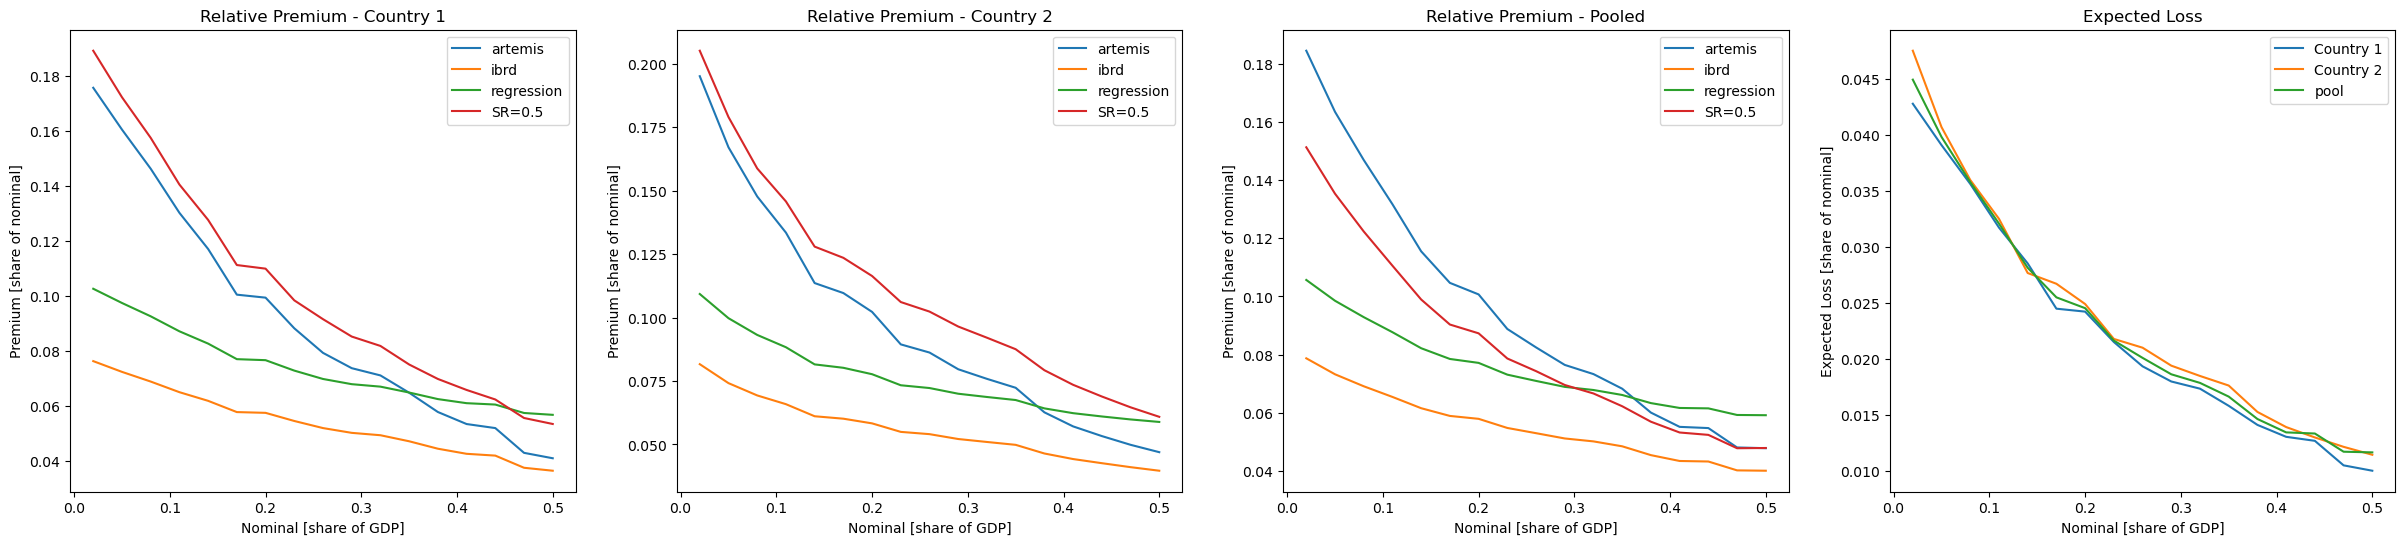

In [14]:
artemis_arr_174 = []
ibrd_arr_174 = []
regression_arr_174 = []
required_arr_174 = []
artemis_arr_662 = []
ibrd_arr_662 = []
regression_arr_662 = []
required_arr_662 = []
requ_prem_pool = []
ibrd_pool = []
artemis_pool = []
regression_pool = []
exp_loss_174 = []
exp_loss_662 = []
exp_loss_pool_arr = []

for ps_share in prot_share_arr:
    ps_str = str(round(ps_share,2))

    artemis_arr_174.append(premium_dic_c1[ps_str]['artemis'])
    ibrd_arr_174.append(premium_dic_c1[ps_str]['ibrd'])
    regression_arr_174.append(premium_dic_c1[ps_str]['regression'])
    required_arr_174.append(premium_dic_c1[ps_str]['required'])

    artemis_arr_662.append(premium_dic_c2[ps_str]['artemis'])
    ibrd_arr_662.append(premium_dic_c2[ps_str]['ibrd'])
    regression_arr_662.append(premium_dic_c2[ps_str]['regression'])
    required_arr_662.append(premium_dic_c2[ps_str]['required'])

    requ_prem_pool.append(premium_dic_pool[ps_str]['required'])
    ibrd_pool.append(premium_dic_pool[ps_str]['ibrd'])
    artemis_pool.append(premium_dic_pool[ps_str]['artemis'])
    regression_pool.append(premium_dic_pool[ps_str]['regression'])

    exp_loss_174.append(premium_dic_c1[ps_str]['exp_loss'])
    exp_loss_662.append(premium_dic_c2[ps_str]['exp_loss'])
    exp_loss_pool_arr.append(premium_dic_pool[ps_str]['exp_loss'])


abs_prem_174  = [e1 * e2 for e1, e2 in zip(required_arr_174, nom_arr_c1)]
abs_prem_662  = [e1 * e2 for e1, e2 in zip(required_arr_662, nom_arr_c2)]
abs_prem_sng  = [e1 + e2 for e1, e2 in zip(abs_prem_174, abs_prem_662)]
abs_prem_pool  = [e1 * e2 for e1, e2 in zip(requ_prem_pool, nominal_arr_pool)]
diff_prem  = [(e1 - e2) / e1 for e1, e2 in zip(abs_prem_sng, abs_prem_pool)]

abs_prem_ibrd_174  = [e1 * e2 for e1, e2 in zip(ibrd_arr_174, nom_arr_c1)]
abs_prem_ibrd_662  = [e1 * e2 for e1, e2 in zip(ibrd_arr_662, nom_arr_c2)]
abs_prem_ibrd_sng  = [e1 + e2 for e1, e2 in zip(abs_prem_ibrd_174, abs_prem_ibrd_662)]
abs_prem_ibrd_pool  = [e1 * e2 for e1, e2 in zip(ibrd_pool, nominal_arr_pool)]
diff_prem_ibrd  = [(e1 - e2) / e1 for e1, e2 in zip(abs_prem_ibrd_sng, abs_prem_ibrd_pool)]



fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 6))

ax1.plot(prot_share_arr, artemis_arr_174, label='artemis')
ax1.plot(prot_share_arr, ibrd_arr_174, label='ibrd')
ax1.plot(prot_share_arr, regression_arr_174, label='regression')
ax1.plot(prot_share_arr, required_arr_174, label=f'SR={requ_sharpe_ratio}')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Premium [share of nominal]')
ax1.set_title('Relative Premium - Country 1')
ax1.legend()

ax2.plot(prot_share_arr, artemis_arr_662, label='artemis')
ax2.plot(prot_share_arr, ibrd_arr_662, label='ibrd')
ax2.plot(prot_share_arr, regression_arr_662, label='regression')
ax2.plot(prot_share_arr, required_arr_662, label=f'SR={requ_sharpe_ratio}')
ax2.set_xlabel('Nominal [share of GDP]')
ax2.set_ylabel('Premium [share of nominal]')
ax2.set_title('Relative Premium - Country 2')
ax2.legend()

ax3.plot(prot_share_arr, artemis_pool, label='artemis')
ax3.plot(prot_share_arr, ibrd_pool, label='ibrd')
ax3.plot(prot_share_arr, regression_pool, label='regression')
ax3.plot(prot_share_arr, requ_prem_pool, label=f'SR={requ_sharpe_ratio}')
ax3.set_xlabel('Nominal [share of GDP]')
ax3.set_ylabel('Premium [share of nominal]')
ax3.set_title('Relative Premium - Pooled')
ax3.legend()

ax4.plot(prot_share_arr, exp_loss_174, label='Country 1')
ax4.plot(prot_share_arr, exp_loss_662, label='Country 2')
ax4.plot(prot_share_arr, exp_loss_pool_arr, label='pool')
ax4.set_xlabel('Nominal [share of GDP]')
ax4.set_ylabel('Expected Loss [share of nominal]')
ax4.set_title('Expected Loss')
ax4.legend()

plt.show()

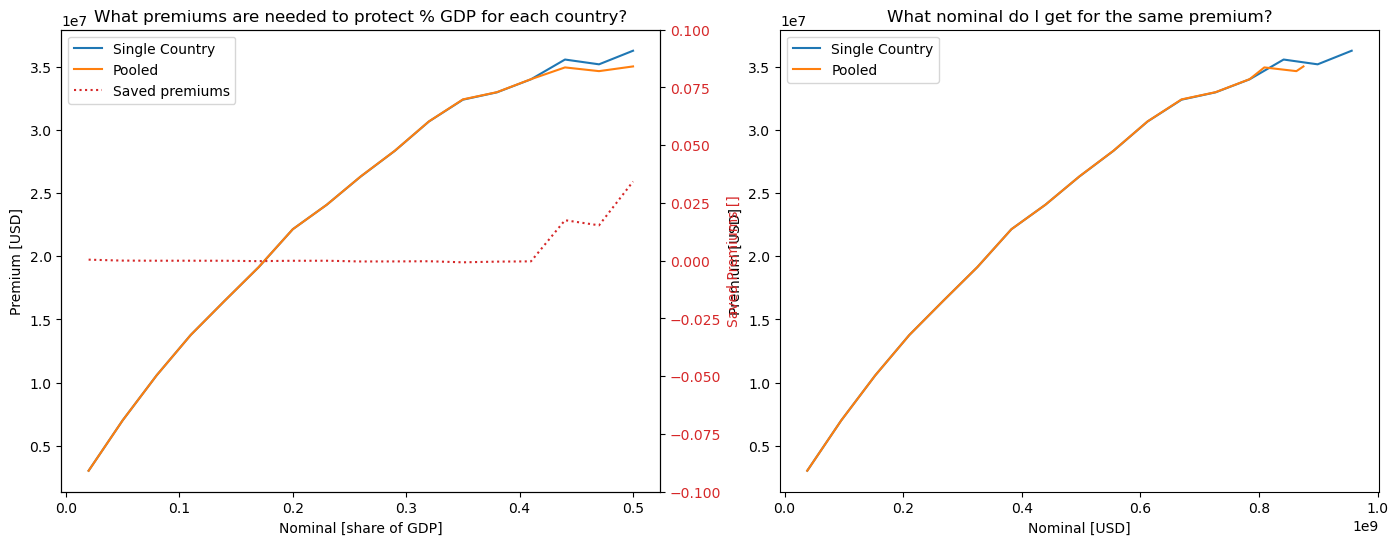

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

ax1.plot(prot_share_arr, abs_prem_ibrd_sng, label='Single Country')
ax1.plot(prot_share_arr, abs_prem_ibrd_pool, label='Pooled')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Premium [USD]')
ax1.set_title('What premiums are needed to protect % GDP for each country?')
ax1.legend()

color='tab:red'
ax1_1 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax1_1.set_ylabel('Saved Premiums []', color=color)  # we already handled the x-label with ax1
ax1_1.plot(prot_share_arr, diff_prem_ibrd, linestyle='dotted', label='Saved premiums', color=color)
ax1_1.tick_params(axis='y', labelcolor=color)
ax1_1.set_ylim(-0.1,0.1)

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax1_1.get_legend_handles_labels()  

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax2.plot(nominal_pool, abs_prem_ibrd_sng, label='Single Country')
ax2.plot(nominal_arr_pool, abs_prem_ibrd_pool, label='Pooled')
ax2.set_xlabel('Nominal [USD]')
ax2.set_ylabel('Premium [USD]')
ax2.set_title('What nominal do I get for the same premium?')
ax2.legend()
plt.show()

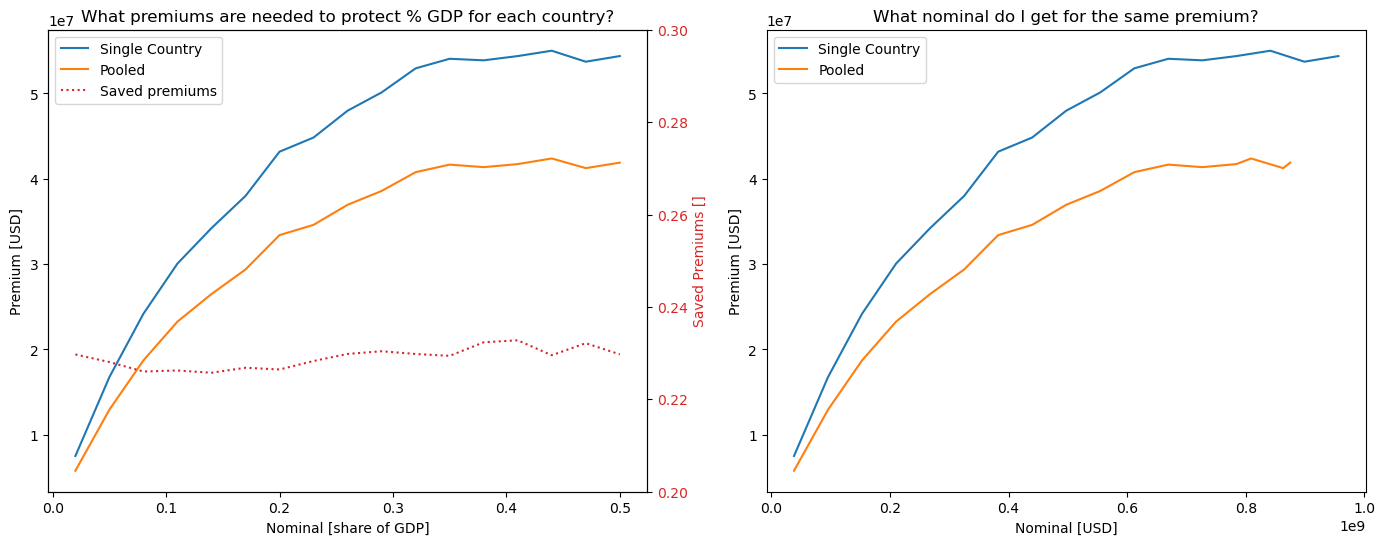

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

ax1.plot(prot_share_arr, abs_prem_sng, label='Single Country')
ax1.plot(prot_share_arr, abs_prem_pool, label='Pooled')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Premium [USD]')
ax1.set_title('What premiums are needed to protect % GDP for each country?')
ax1.legend()

color='tab:red'
ax1_1 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax1_1.set_ylabel('Saved Premiums []', color=color)  # we already handled the x-label with ax1
ax1_1.plot(prot_share_arr, diff_prem, linestyle='dotted', label='Saved premiums', color=color)
ax1_1.tick_params(axis='y', labelcolor=color)
ax1_1.set_ylim(0.2,0.3)

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax1_1.get_legend_handles_labels()  

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax2.plot(nominal_pool, abs_prem_sng, label='Single Country')
ax2.plot(nominal_arr_pool, abs_prem_pool, label='Pooled')
ax2.set_xlabel('Nominal [USD]')
ax2.set_ylabel('Premium [USD]')
ax2.set_title('What nominal do I get for the same premium?')
ax2.legend()
plt.show()

### Coverage

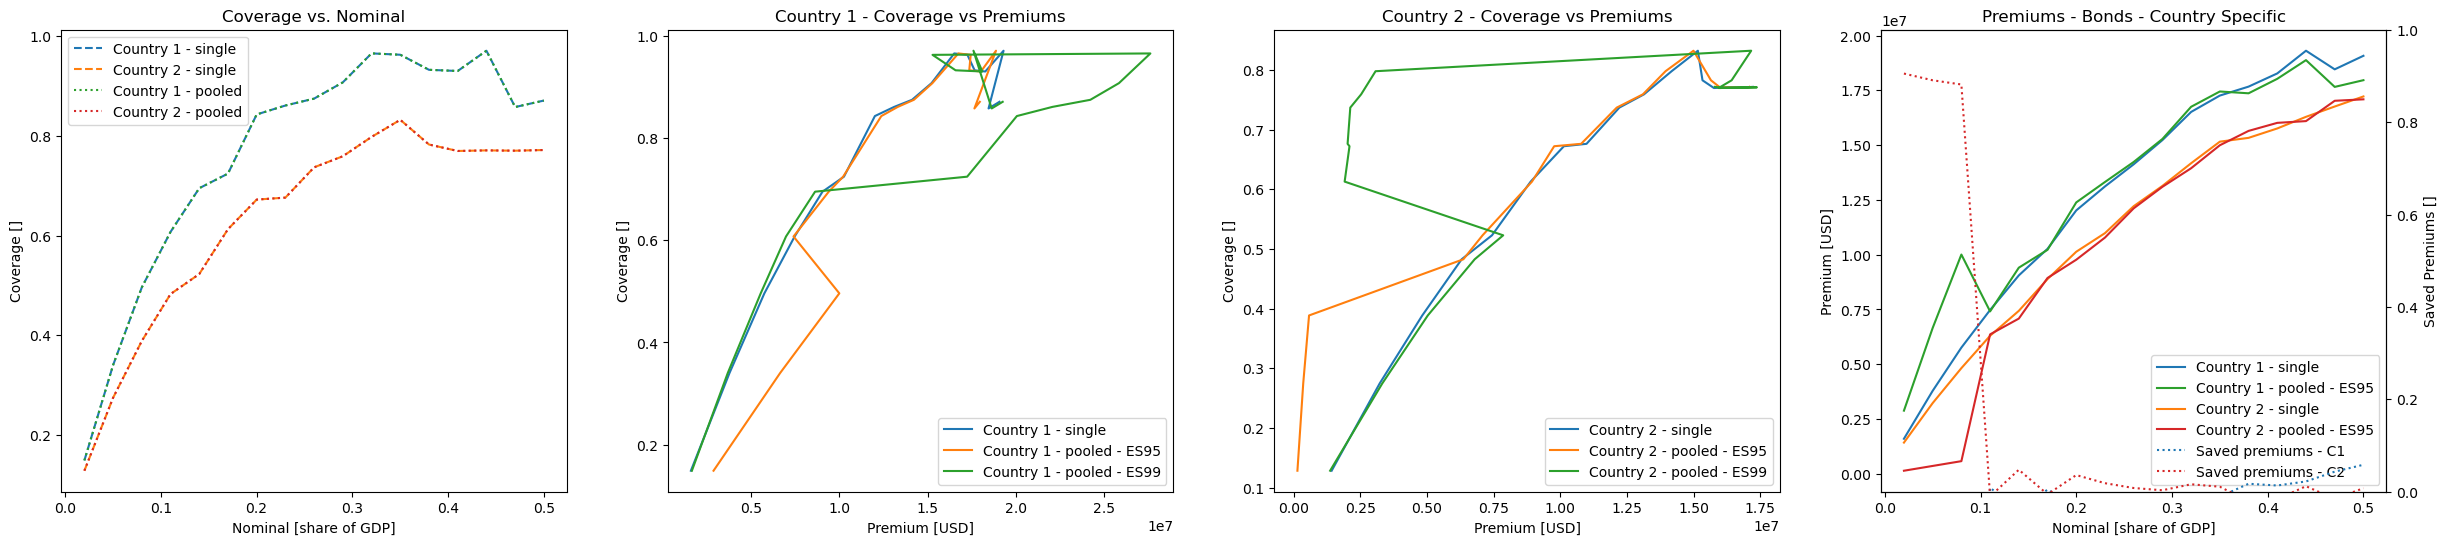

In [18]:
cov_174 = []
cov_662 = []
cov_pool_174 = []
cov_pool_662 = []
abs_prem_pool_99_174 = []
abs_prem_pool_99_662 = []
abs_prem_pool_95_174 = []
abs_prem_pool_95_662 = []


for i in range(len(prot_share_arr)):
    ps_str = str(round(prot_share_arr[i], 2))

    cov_174.append(np.mean(premium_simulation_ps_c1[ps_str]['Coverage']))
    cov_662.append(np.mean(premium_simulation_ps_c2[ps_str]['Coverage']))    
    cov_pool_174.append(np.mean(tot_coverage_prem_cty_ps_pool[ps_str]['308']['coverage']))
    cov_pool_662.append(np.mean(tot_coverage_prem_cty_ps_pool[ps_str]['882']['coverage']))

    abs_prem_pool_95_174.append(MES_cty_ps_pool[ps_str]['308']['95'] / es_metrics_ps_pool[ps_str]['ES_95_ann'] * premium_dic_pool[ps_str]['ibrd'] * nominal_arr_pool[i])
    abs_prem_pool_95_662.append(MES_cty_ps_pool[ps_str]['882']['95'] / es_metrics_ps_pool[ps_str]['ES_95_ann'] * premium_dic_pool[ps_str]['ibrd'] * nominal_arr_pool[i])
    abs_prem_pool_99_174.append(MES_cty_ps_pool[ps_str]['308']['99'] / es_metrics_ps_pool[ps_str]['ES_99_ann'] * premium_dic_pool[ps_str]['ibrd'] * nominal_arr_pool[i])
    abs_prem_pool_99_662.append(MES_cty_ps_pool[ps_str]['882']['99'] / es_metrics_ps_pool[ps_str]['ES_99_ann'] * premium_dic_pool[ps_str]['ibrd'] * nominal_arr_pool[i])

diff_prem_c1  = [(e1 - e2) / e1 for e1, e2 in zip(abs_prem_ibrd_174, abs_prem_pool_95_174)]
diff_prem_c2  = [(e1 - e2) / e1 for e1, e2 in zip(abs_prem_ibrd_662, abs_prem_pool_95_662)]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 6))

ax1.plot(prot_share_arr, cov_174, label='Country 1 - single', linestyle="dashed")
ax1.plot(prot_share_arr, cov_662, label='Country 2 - single', linestyle="dashed")
ax1.plot(prot_share_arr, cov_pool_174, label='Country 1 - pooled', linestyle="dotted")
ax1.plot(prot_share_arr, cov_pool_662, label='Country 2 - pooled', linestyle="dotted")
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Coverage []')
ax1.set_title('Coverage vs. Nominal')
ax1.legend()

ax2.plot(abs_prem_ibrd_174, cov_174, label='Country 1 - single')
ax2.plot(abs_prem_pool_95_174, cov_pool_174, label='Country 1 - pooled - ES95')
ax2.plot(abs_prem_pool_99_174, cov_pool_174, label='Country 1 - pooled - ES99')
ax2.set_xlabel('Premium [USD]')
ax2.set_ylabel('Coverage []')
ax2.set_title('Country 1 - Coverage vs Premiums')
ax2.legend()

ax3.plot(abs_prem_ibrd_662, cov_662, label='Country 2 - single')
ax3.plot(abs_prem_pool_95_662, cov_pool_662, label='Country 2 - pooled - ES95')
ax3.plot(abs_prem_pool_99_662, cov_pool_662, label='Country 2 - pooled - ES99')
ax3.set_xlabel('Premium [USD]')
ax3.set_ylabel('Coverage []')
ax3.set_title('Country 2 - Coverage vs Premiums')
ax3.legend()

ax4.plot(prot_share_arr, abs_prem_ibrd_174, color='tab:blue', label='Country 1 - single')
ax4.plot(prot_share_arr, abs_prem_pool_95_174, color='tab:green', label='Country 1 - pooled - ES95')
ax4.plot(prot_share_arr, abs_prem_ibrd_662, color='tab:orange', label='Country 2 - single')
ax4.plot(prot_share_arr, abs_prem_pool_95_662, color='tab:red', label='Country 2 - pooled - ES95')
ax4.set_xlabel('Nominal [share of GDP]')
ax4.set_ylabel('Premium [USD]')
ax4.set_title('Premiums - Bonds - Country Specific')

ax5 = ax4.twinx()  # instantiate a second Axes that shares the same x-axis
ax5.set_ylabel('Saved Premiums []')  # we already handled the x-label with ax1
ax5.plot(prot_share_arr, diff_prem_c1, linestyle='dotted', label='Saved premiums - C1', color='tab:blue')
ax5.plot(prot_share_arr, diff_prem_c2, linestyle='dotted', label='Saved premiums - C2', color='tab:red')
ax5.set_ylim(0,1)
ax5.tick_params(axis='y')

lines1, labels1 = ax4.get_legend_handles_labels()  
lines2, labels2 = ax5.get_legend_handles_labels()  

ax4.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.show()

### Performance

In [19]:
shp_rat_requ_prem_prot = []
shp_rat_ibrd_prem_prot = []
shp_rat_c1 = []
shp_rat_c2 = []
requ_prem_returns_pool = {}

for i in range(len(prot_share_arr)):
    ps_str = str(round(prot_share_arr[i],2))
    ps_ibrd_prem_174, ret_ibrd_prem_174 = sb.init_bond_simulation(pay_dam_df_ps_c1[ps_str], ibrd_arr_174[i], rf_rate, nom_arr_c1[i]) #simulate cat bond using a Monte Carlo simulation
    ps_ibrd_prem_662, ret_ibrd_prem_662 = sb.init_bond_simulation(pay_dam_df_ps_c2[ps_str], ibrd_arr_662[i], rf_rate, nom_arr_c2[i]) #simulate cat bond using a Monte Carlo simulation
    ann_returns_requ_prem_sng = ((returns_ps_c1[ps_str]['Annual'][0] * nom_arr_c1[i]) + (returns_ps_c2[ps_str]['Annual'][0] * nom_arr_c2[i])) / (nom_arr_c1[i] + nom_arr_c2[i])
    ann_returns_ibrd_prem_sng = ((ret_ibrd_prem_174['Annual'][0] * nom_arr_c1[i]) + (ret_ibrd_prem_662['Annual'][0] * nom_arr_c2[i])) / (nom_arr_c1[i] + nom_arr_c2[i])
    shp_rat_requ_prem_prot.append(sb.init_sharpe_ratio(ann_returns_requ_prem_sng, rf_rate))
    shp_rat_ibrd_prem_prot.append(sb.init_sharpe_ratio(ann_returns_ibrd_prem_sng, rf_rate))
    shp_rat_c1.append(sb.init_sharpe_ratio(returns_ps_c1[ps_str]['Annual'][0], rf_rate))
    shp_rat_c2.append(sb.init_sharpe_ratio(returns_ps_c2[ps_str]['Annual'][0], rf_rate))

    pay_dam_df_dic = {country_1: pay_dam_df_ps_c1[ps_str],
                      country_2: pay_dam_df_ps_c2[ps_str]}
    requ_prem_metrics_pool, requ_prem_returns_pool[ps_str], requ_prem_tot_coverage_pool_cty = smcb.init_bond_simulation(pay_dam_df_dic, requ_prem_pool[i], rf_rate, nominal_pool[i], countries)

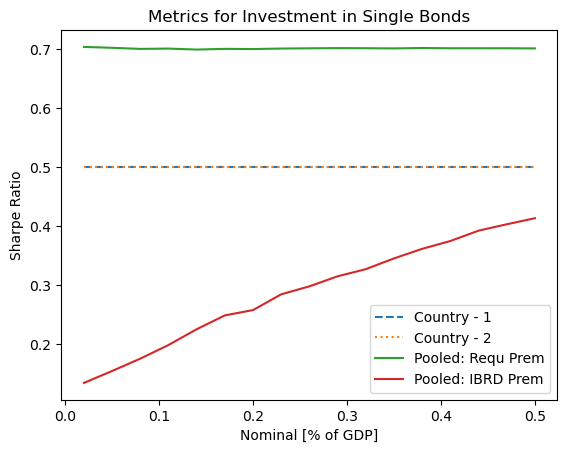

In [23]:
plt.plot(prot_share_arr, shp_rat_c1, linestyle='dashed', label='Country - 1')
plt.plot(prot_share_arr, shp_rat_c2, linestyle='dotted', label='Country - 2')
plt.plot(prot_share_arr, shp_rat_requ_prem_prot, label='Pooled: Requ Prem')
plt.plot(prot_share_arr, shp_rat_ibrd_prem_prot, label='Pooled: IBRD Prem')
plt.xlabel('Nominal [% of GDP]')
plt.ylabel('Sharpe Ratio')
plt.title('Metrics for Investment in Single Bonds')
plt.legend()
plt.show()

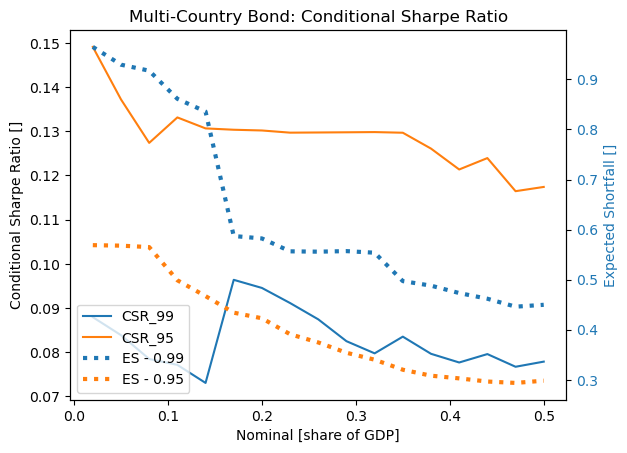

In [24]:
CSR_99 = []
CSR_95 = []
es_99_pool = []
es_95_pool = []

for ps_share in prot_share_arr:
    ps_str = str(round(ps_share,2)) 
    ES_99_nom = es_metrics_ps_pool[ps_str]['ES_99_ann']
    ES_95_nom = es_metrics_ps_pool[ps_str]['ES_95_ann']

    es_99_pool.append(ES_99_nom)
    es_95_pool.append(ES_95_nom)
    
    CSR_99.append(smcb.init_sharpe_ratio(requ_prem_returns_pool[ps_str]['Annual'][0], rf_rate, ES_99_nom))
    CSR_95.append(smcb.init_sharpe_ratio(requ_prem_returns_pool[ps_str]['Annual'][0], rf_rate, ES_95_nom))

fig, ax1 = plt.subplots()

ax1.plot(prot_share_arr, CSR_99, label='CSR_99')
ax1.plot(prot_share_arr, CSR_95, label='CSR_95')
ax1.set_title('Multi-Country Bond: Conditional Sharpe Ratio')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Conditional Sharpe Ratio []')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:blue'
color1 = 'tab:orange'
ax2.set_ylabel('Expected Shortfall []', color=color) 
ax2.plot(prot_share_arr, es_99_pool, color=color, linestyle='dotted', linewidth='3.0', label='ES - 0.99')
ax2.plot(prot_share_arr, es_95_pool, color=color1, linestyle='dotted', linewidth='3.0', label='ES - 0.95')
ax2.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax2.get_legend_handles_labels()  

ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')
plt.show()

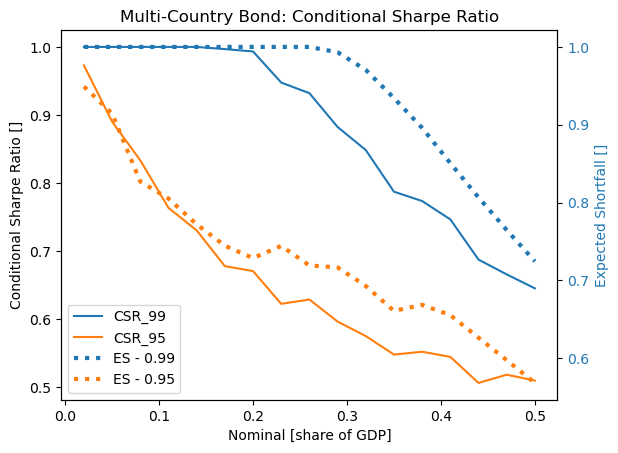

In [32]:
es_99_1 = []
es_95_1 = []
es_99_2 = []
es_95_2 = []

for ps_share in prot_share_arr:
    ps_str = str(round(ps_share,2)) 
    ES_99_1 = es_metrics_ps_c1[ps_str]['ES_99_ann']
    ES_95_1 = es_metrics_ps_c1[ps_str]['ES_95_ann']
    ES_99_2 = es_metrics_ps_c2[ps_str]['ES_99_ann']
    ES_95_2 = es_metrics_ps_c2[ps_str]['ES_95_ann']

    es_99_1.append(ES_99_1)
    es_95_1.append(ES_95_1)
    es_99_2.append(ES_99_2)
    es_95_2.append(ES_95_2)
    

fig, ax1 = plt.subplots()

ax1.plot(prot_share_arr, es_99_1, label='CSR_99')
ax1.plot(prot_share_arr, es_95_1, label='CSR_95')
ax1.set_title('Multi-Country Bond: Conditional Sharpe Ratio')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Conditional Sharpe Ratio []')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:blue'
color1 = 'tab:orange'
ax2.set_ylabel('Expected Shortfall []', color=color) 
ax2.plot(prot_share_arr, es_99_2, color=color, linestyle='dotted', linewidth='3.0', label='ES - 0.99')
ax2.plot(prot_share_arr, es_95_2, color=color1, linestyle='dotted', linewidth='3.0', label='ES - 0.95')
ax2.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax2.get_legend_handles_labels()  

ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')
plt.show()

### Cost-Benefit

In [22]:
tot_exp_174 = nom_arr_c1[9] / prot_share_arr[9] 
tot_exp_662 = nom_arr_c2[9] / prot_share_arr[9] 


avg_pay_rel_gdp_174 = []
avg_pay_rel_gdp_662 = []
avg_pay_abs_174 = []
avg_pay_abs_662 = []
avg_pay_prot = []


for i in range(len(prot_share_arr)):
    ps_str = str(round(prot_share_arr[i],2))
    avg_pay_prot.append(premium_simulation_ps_pool[ps_str]['Average Payments'])
    avg_pay_rel_gdp_174.append(np.sum(tot_coverage_prem_cty_ps_pool[ps_str]['659']['payout']) / (num_simulations - tot_coverage_prem_cty_ps_pool[ps_str]['659']['count_zero']) / tot_exp_174)
    avg_pay_rel_gdp_662.append(np.sum(tot_coverage_prem_cty_ps_pool[ps_str]['52']['payout']) / (num_simulations - tot_coverage_prem_cty_ps_pool[ps_str]['52']['count_zero']) / tot_exp_662)
    avg_pay_abs_174.append(np.sum(tot_coverage_prem_cty_ps_pool[ps_str]['659']['payout']) / (num_simulations - tot_coverage_prem_cty_ps_pool[ps_str]['659']['count_zero']))
    avg_pay_abs_662.append(np.sum(tot_coverage_prem_cty_ps_pool[ps_str]['52']['payout']) / (num_simulations - tot_coverage_prem_cty_ps_pool[ps_str]['52']['count_zero']))

rel_prem_pool_95_174 = (np.array(abs_prem_pool_95_174)*3/tot_exp_174)
rel_prem_pool_95_662 = (np.array(abs_prem_pool_95_662)*3/tot_exp_662)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(prot_share_arr, rel_prem_pool_95_174, label='Premium - Country 1')
ax1.plot(prot_share_arr, rel_prem_pool_95_662, label='Premium - Country 2')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Premium [share of GDP]')
ax1.set_title('Mult-Country Bond: Premiums and Avg. Payments')
ax1.set_ylim(0,np.max(rel_prem_pool_95_662))
ax1.tick_params(axis='y')

ax1_1 = ax1.twinx() 

color = 'tab:blue'
color1 = 'tab:orange'
ax1_1.set_ylabel('Average Payment [share of GDP]', color=color) 
ax1_1.plot(prot_share_arr, avg_pay_rel_gdp_174, color=color, linestyle='dotted', linewidth='3.0', label='Avg. Payout - Country 1')
ax1_1.plot(prot_share_arr, avg_pay_rel_gdp_662, color=color1, linestyle='dotted', linewidth='3.0', label='Avg. Payout - Country 2')
ax1_1.set_ylim(0,np.max(avg_pay_rel_gdp_662))
ax1_1.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax1_1.get_legend_handles_labels()  

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax2.plot(prot_share_arr, prot_share_arr/rel_prem_pool_95_174, label='Premium - Country 1')
ax2.plot(prot_share_arr, prot_share_arr/rel_prem_pool_95_662, label='Premium - Country 2')
ax2.set_xlabel('Nominal [share of GDP]')
ax2.set_ylabel('Principal / Premium')
ax2.set_title('Mult-Country Bond: Premiums vs Principal')

ax2.legend()

plt.show()

KeyError: '659'

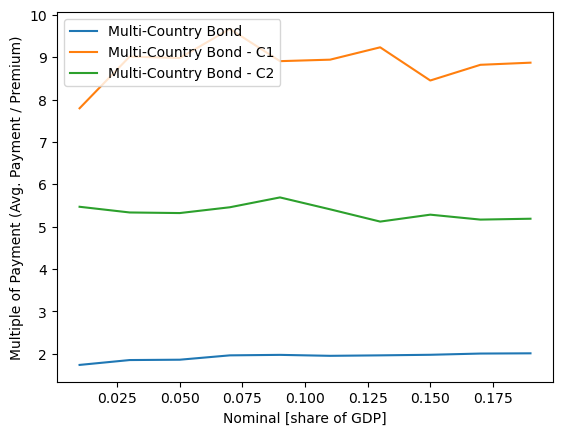

In [130]:
pay_multip  = [e1 / e2 for e1, e2 in zip(avg_pay_prot, np.array(abs_prem_pool)*3)]
pay_multip_174  = [e1 / e2 for e1, e2 in zip(avg_pay_abs_174, np.array(abs_prem_pool_95_174)*3)]
pay_multip_662  = [e1 / e2 for e1, e2 in zip(avg_pay_abs_662, np.array(abs_prem_pool_95_662)*3)]


plt.plot(prot_share_arr, pay_multip, label='Multi-Country Bond')
plt.plot(prot_share_arr, pay_multip_174, label='Multi-Country Bond - C1')
plt.plot(prot_share_arr, pay_multip_662, label='Multi-Country Bond - C2')

plt.xlabel('Nominal [share of GDP]')
plt.ylabel('Multiple of Payment (Avg. Payment / Premium)')
plt.legend()
plt.show()

In [29]:
f_99 = returns_ps_pool['0.14']['Annual'][0].quantile(0.99)
z_99 = returns_ps_pool['0.17']['Annual'][0].quantile(0.99)
print(f_99)
print(z_99)


0.14896537032448234
0.14035782877136038


In [60]:
z = ann_losses_pool['0.14'].quantile(0.99)
q = ann_losses_pool['0.17'].quantile(0.99)
print(z)
print(q)

0.5456287948261523
0.542698563099454


In [59]:
ES_99_z = ann_losses_pool['0.14'][ann_losses_pool['0.14'] > z].mean()
ES_99_q = ann_losses_pool['0.17'][ann_losses_pool['0.17'] > q].mean()
print(ES_99_z)
print(ES_99_q)

0.8356140025237113
0.5871409968818921


In [71]:
t = ann_losses_pool['0.17'][ann_losses_pool['0.17'] > q]
p = ann_losses_pool['0.14'][ann_losses_pool['0.14'] > z]

In [70]:
t = pay_dam_df_ps_c1['0.17']
t['pay'][78]/nominal_arr_pool[5]

0.5456287948261523

In [131]:
#save session varibales in database file
dill.dump_session('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/sessions/pooled_bond_100824.db')